In [1]:
from exp_nume_ex import exp_Short_FISTA
from exp_nume_ex import exp_parameter
from exp_nume_ex import lattice
from exp_nume_ex import exp_kakunou
from exp_nume_ex import exp_qseplot
import time
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import csv
import os

from scipy.spatial import distance
from scipy.optimize import linprog
from scipy.optimize import minimize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.font_manager import FontProperties

## 真値計算

In [2]:
E_list = [5]
Col_list = [20, 30]
for Col in Col_list:
 
    for E in E_list:
        print("="*40)
        print(f"E={E}, K={Col}^2")

        K = Col * Col

        M = 90
        N = 90

#         dF_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
#             fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_F.xlsx')
#         dH_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
#             fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_H.xlsx')

#         m_fixed = np.array(dF_long['m'].tolist())
#         n_fixed = np.array(dH_long['n'].tolist()).reshape(K, K)

        m_per = M / K
        m_fixed = np.array([m_per] * K)
        n_fixed = np.full((K, K), N / (K * K))

        # Scaling * tが格子の最小距離となる。

        Scaling = 300 / Col

        alter_T_num = 0.5

        city_network = lattice.make_lattice(Col)

        # 通勤費用パラメータ
        t = 0.1

        # 距離抵抗パラメータ
        tau = 0.01

        # 総土地供給量
        S_total = 900
        S_bar = S_total / K

        Coordinate_Data = \
        np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
                   city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
        distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

        theta_firm = 5.0
        theta_house = 5.0

        alpha_1 = 0.4
        alpha_2 = 0.4
        beta_1 = 0.4
        beta_2 = 0.4

        L = 0.2
        eta = 1.2
        p_proj = 1e-3

        RW_ini = 1.0
        RW_proj = 1e-3
        err_short = "400iteration"

        method = "FISTA"
        long = "ichiyou"
        dic = "mesh_300divCol"

        R_ini = np.ones(K)
        W_ini = np.ones(K)

        #パラメータ設定
        prm = exp_parameter.Parameter(
                    Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
                    theta_firm, theta_house, E, RW_proj, alter_T_num,
                    alpha_1, alpha_2, beta_1, beta_2, M, N)

        algprm = exp_parameter.Algo_Parameter(L, eta, p_proj)
        short = exp_Short_FISTA.Short(prm, algprm)
        
        dF = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/exp/excelfile/' \
                           fr'short/long_{long}/{method}/err_short={err_short}/{dic}/RW_proj={prm.RW_proj}/alter_T_num={prm.alter_T_num}/' \
                           fr'L={algprm.L}/eta={algprm.eta}/p_proj={algprm.p_proj}/E={prm.E}/K={prm.Col}^2/truevalue/jikken_F.xlsx')
        
        R_corr = np.array(dF['R'].tolist())
        W_corr = np.array(dF['W'].tolist())
        
        RW_corr = np.concatenate((R_corr, W_corr))
        
        obj_corr = short.Z_SD(RW_corr, m_fixed, n_fixed)

        alter_T = alter_T_num * Scaling * t

        # step.1-1
        start_time = time.process_time()
        R_true, W_true, iteration, obj_rel_list = \
        short.short_solve(RW_ini, m_fixed, n_fixed, err_short, obj_corr, 
                          short_itr=400, rel=0)
        end_time = time.process_time()
        elapsed_time = end_time - start_time

        pi_true = short.pi(R_true, W_true, m_fixed)
        v_true = short.v(R_true, W_true)

        RW_true = np.concatenate((R_true, W_true))

        print("CPU_time:", elapsed_time, "秒")
        
        err_short = "obj_smaller_1e-4"

        exp_kakunou.short_kakunou_true(R_true, W_true, pi_true, v_true, prm, algprm, long, method, err_short, dic)
        exp_kakunou.short_kakunou_nume_num(iteration, prm, algprm, long, method, err_short, dic)
        exp_kakunou.short_kakunou_rel_obj(obj_rel_list, prm, algprm, long, method, err_short, dic)

E=5, K=20^2
short_max_value: 14
equ_R: -0.0026387979799751544
equ_W: 0.008841201846108378
CPU_time: 1.6875 秒
E=5, K=30^2
short_max_value: 15
equ_R: -0.0007596084102302026
equ_W: 0.0014735840894792413
CPU_time: 8.3125 秒


## 真値計算 + グラフ描画

short_max_value: 293
Lyapunov: -3.21972324516468e-06
short_max_value: 568
Lyapunov: 5.444893486485084e-06
short_max_value: 68
Lyapunov: -8.503664663920502e-08


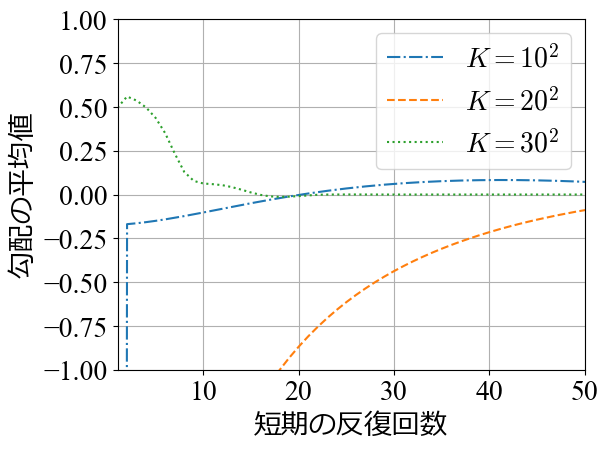

short_max_value: 132
Lyapunov: 2.9582594693031866e-08
short_max_value: 45
Lyapunov: 1.2831624776000453e-09
short_max_value: 570
Lyapunov: 2.0686019934595287e-05


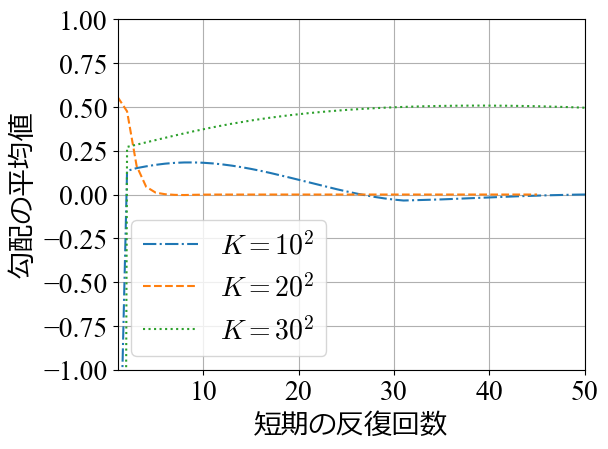

In [17]:
E_list = [8, 10]
Col_list = [10, 20, 30]
itr_list = []
grad_list = []
for E in E_list:
    
    for Col in Col_list:
        
        print("="*40)
    
        K = Col * Col

        M = 0.1 * K
        N = 0.1 * K

        dF_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'shortlong/FISTA/theta=5.0/E=10/mesh/K={Col}^2/truevalue/jikken_F.xlsx')
        dH_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'shortlong/FISTA/theta=5.0/E=10/mesh/K={Col}^2/truevalue/jikken_H.xlsx')

        m_fixed = np.array(dF_long['m'].tolist())
        n_fixed = np.array(dH_long['n'].tolist()).reshape(K, K)

        # m_per = M / K
        # m_fixed = np.array([m_per] * K)
        # n_fixed = np.full((K, K), N / (K * K))

        # Scaling * tが格子の最小距離となる。
        Scaling = 0.15

        city_network = lattice.make_lattice(Col)

        # 通勤費用パラメータ
        t = 0.1

        # 距離抵抗パラメータ
        tau = 0.01

        # 総土地供給量
        S_total = K
        S_bar = S_total / K

        Coordinate_Data = \
        np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
                   city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
        distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

        theta_N = 5.0
        theta_M = 5.0

        # E = 5

        alpha_1 = 0.4
        alpha_2 = 0.4
        beta_1 = 0.4
        beta_2 = 0.4
        
        L = 0.2
        eta = 1.2
        p_proj = 0.1
        
        RW_ini = 1.0
    
        #パラメータ設定
        prm = Short_Algo.Parameter(Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
                    theta_M, theta_N, E, alpha_1, alpha_2, beta_1, beta_2, M, N)
        algprm = Short_Algo.Algo_Parameter(L, eta, p_proj)
        short = Short_Algo.Short(prm, algprm, m_fixed, n_fixed)
    
        #step.1-1
        R_true, W_true, iteration, err_R, err_W, err_v, err_pi, err_obj, grad_mean =\
        short.short_solve(RW_ini, R_corr=None, W_corr=None, pi_corr=None, v_corr=None, obj_corr=None,
                          short_itr=10001, err_short=10**(-8), rel=0)

        pi_true = short.pi(R_true, W_true)
        v_true = short.v(R_true, W_true)
        
        itr_list.append(iteration)
        grad_list.append(grad_mean)

        #step.1-2
#         true_path_f, true_path_h = kakunou.kakunou_true(R_true, W_true, pi_true, v_true, prm, algprm)
        
#         print("true_path_f:", true_path_f)
#         print("true_path_h:", true_path_h)
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'cm'  # 数式フォントもTimes New Romanに設定

    font_path = r'C:\Windows\Fonts\meiryo.ttc'  # フォントのパスを指定
    jp_font = FontProperties(fname=font_path)
    
    plt.plot(itr_list[0], grad_list[0], '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(itr_list[1], grad_list[1], '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(itr_list[2], grad_list[2], ':', label = f'$K = {Col_list[2]}^2$')
    # plt.yscale('log')

    plt.legend(fontsize=20)
    
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('勾配の平均値', fontproperties=jp_font, fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=50)
    plt.ylim(top=1, bottom=-1)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()
    
    itr_list.clear()
    grad_list.clear()

## 相対誤差計算 + グラフ描画

In [ ]:
E_list = [1, 2, 5, 8, 10]
Col_list = [10, 20, 30]
rel_path_list = []
for E in E_list:
    
    for Col in Col_list:
        
        print("="*40)
        print(f'K={Col}^2, E={E}')
        
        K = Col * Col
    
        M = 0.1 * K
        N = 0.1 * K

        # Scaling * tが格子の最小距離となる。
        Scaling = 3 / Col

        city_network = lattice.make_lattice(Col)

        # 通勤費用パラメータ
        t = 0.1

        # 距離抵抗パラメータ
        tau = 0.01

        # 総土地供給量
        S_total = K
        S_bar = S_total / K

        Coordinate_Data = \
        np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
                   city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
        distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

        theta_N = 5.0
        theta_M = 5.0

        # E = 5

        alpha_1 = 0.4
        alpha_2 = 0.4
        beta_1 = 0.4
        beta_2 = 0.4
        
        L = 0.2
        eta = 1.2
        p_proj = 0.1
    
        #パラメータ設定
        prm = Short_Algo.Parameter(Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
                    theta_M, theta_N, E, alpha_1, alpha_2, beta_1, beta_2, M, N)
        algprm = Short_Algo.Algo_Parameter(L, eta, p_proj)

        #長期の変数の設定
        dF_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'shortlong/FISTA/theta=5.0/E=10/mesh/K={Col}^2/truevalue/jikken_F.xlsx')
        dH_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'shortlong/FISTA/theta=5.0/E=10/mesh/K={Col}^2/truevalue/jikken_H.xlsx')

        m_fixed = np.array(dF_long['m'].tolist())
        n_fixed = np.array(dH_long['n'].tolist()).reshape(K, K)

        # m_per = M / K
        # m_fixed = np.array([m_per] * K)
        # n_fixed = np.full((K, K), N / (K * K))
        
        short = Short_Algo.Short(prm, algprm, m_fixed, n_fixed)
        
        dF_FISTA = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
            fr'short/FISTA/long_shuseki/mesh/E={prm.E}/L={algprm.L}/p_proj={algprm.p_proj}/v_proj=0.1/df=None/K={prm.Col}^2/truevalue/jikken_F.xlsx')
        dH_FISTA = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
            fr'short/FISTA/long_shuseki/mesh/E={prm.E}/L={algprm.L}/p_proj={algprm.p_proj}/v_proj=0.1/df=None/K={prm.Col}^2/truevalue/jikken_H.xlsx')
        
        R_true = np.array(dF_FISTA['R'].tolist())
        W_true = np.array(dF_FISTA['W'].tolist())
        pi_true = np.array(dF_FISTA['pi'].tolist())
        v_true = np.array(dH_FISTA['v'].tolist()).reshape(K, K)
        
        RW_true = np.concatenate((R_true, W_true))
        obj_true = short.Z_SD(RW_true)
        
        RW_ini = 1.0

        #step.1-3
        R, W, iteration, err_R, err_W, err_v, err_pi, err_obj =\
        short.short_solve(RW_ini, R_true, W_true, pi_true, v_true, obj_true, 
                          short_itr=3001, err_short=10**(-8), rel=1)

        #step.1-4
        rel_path = kakunou.kakunou_rel\
        (iteration, err_R, err_W, err_v, err_pi, err_obj, prm, algprm)

        rel_path_list.append(rel_path)

    #step.2
    print("len(rel_path_list):", len(rel_path_list))
    qseplot.rel_plot(rel_path_list, Col_list, prm, algprm)
    
    rel_path_list.clear()

## 真値計算 + 相対誤差計算 + グラフ描画

err_short=0.001, E=5, K=10^2
short_max_value: 10
jac: 0.0012533026616464915
equ_R: -0.0007812026776050995
equ_W: 0.004221715421507362
short_max_value: 10
jac: 0.0012533026616464915
equ_R: -0.0007812026776050995
equ_W: 0.004221715421507362
err_short=0.001, E=5, K=20^2
short_max_value: 18
jac: 0.00024318661904189514
equ_R: -0.00022876964648822353
equ_W: 0.0012619561354189097
short_max_value: 18
jac: 0.00024318661904189514
equ_R: -0.00022876964648822353
equ_W: 0.0012619561354189097
err_short=0.001, E=5, K=30^2
short_max_value: 24
jac: 0.004374194583197173
equ_R: -0.0013837215157552687
equ_W: 0.02181010933375973
short_max_value: 24
jac: 0.004374194583197173
equ_R: -0.0013837215157552687
equ_W: 0.02181010933375973
len(rel_path_list): 3


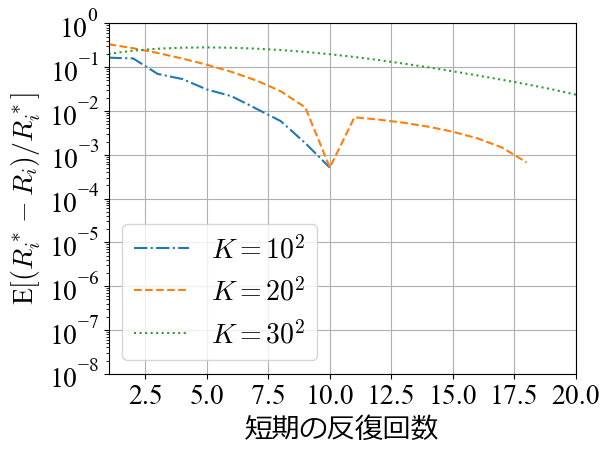

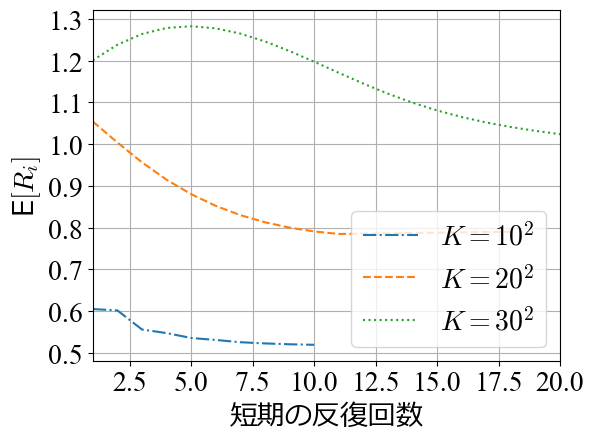

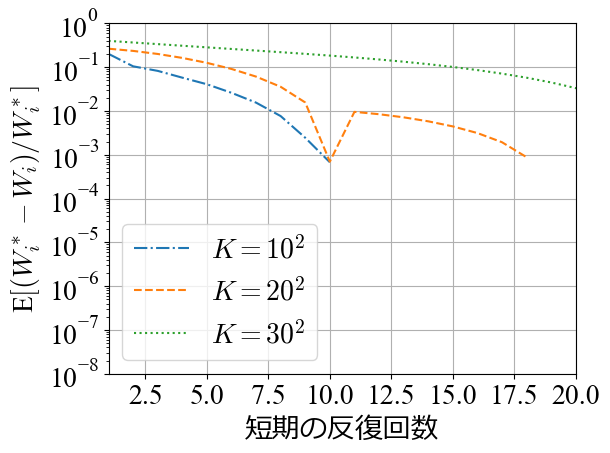

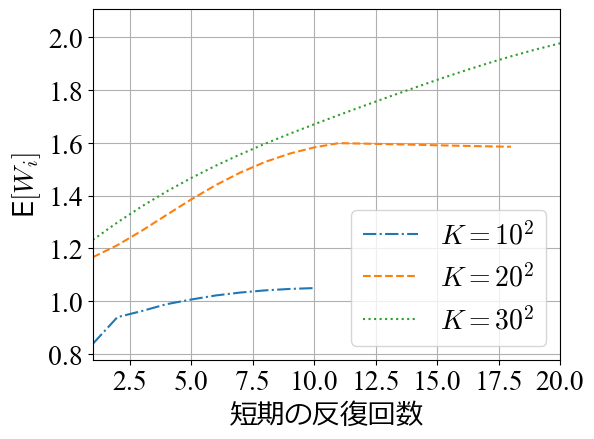

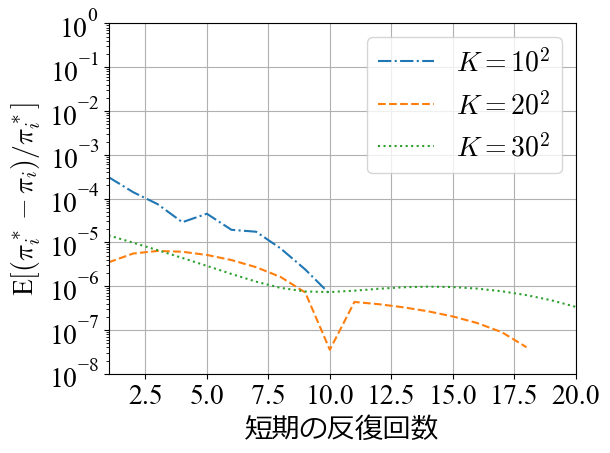

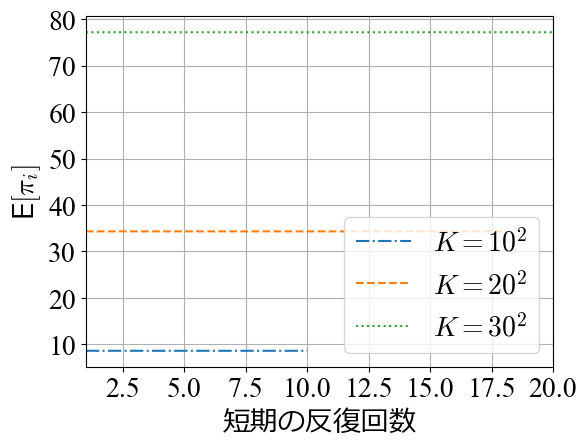

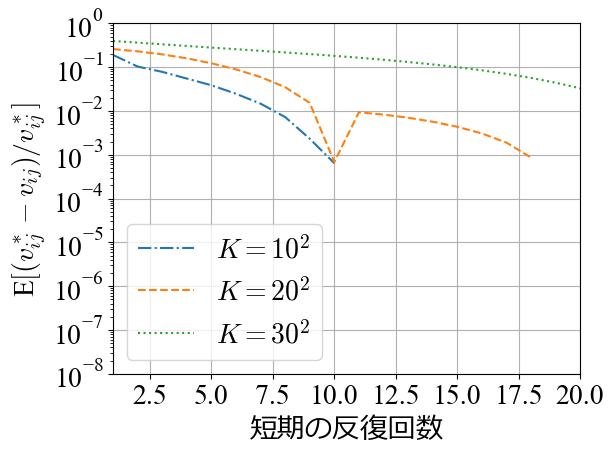

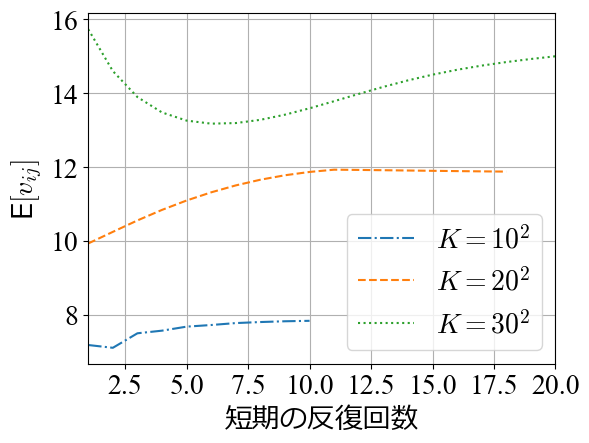

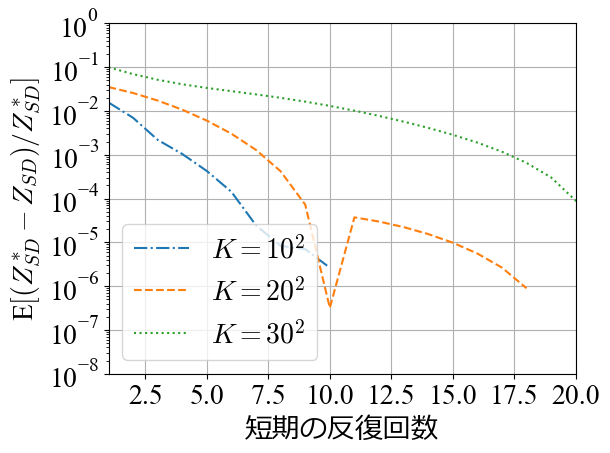

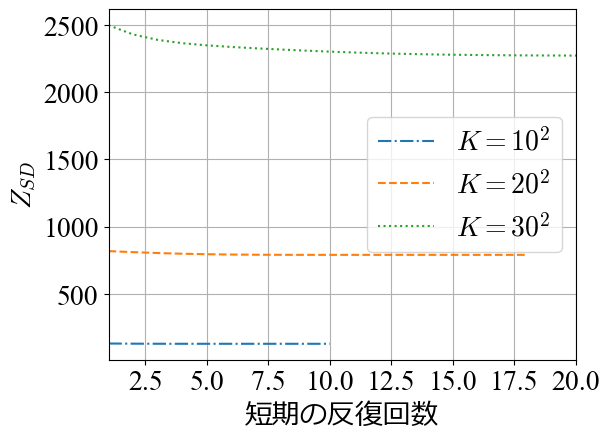

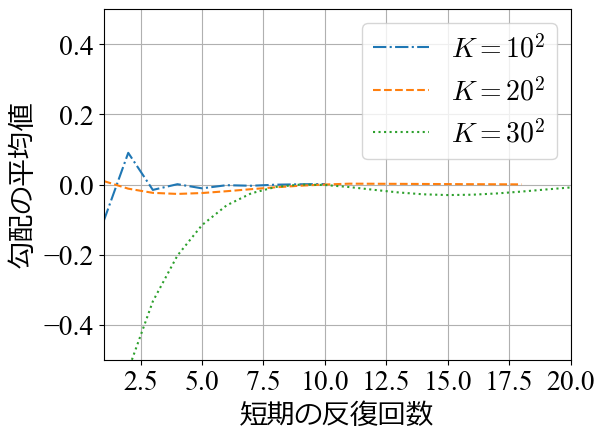

err_short=0.001, E=8, K=10^2
short_max_value: 11
jac: 0.000367866842368247
equ_R: -0.0010940117673168565
equ_W: 0.0020142332415280955
short_max_value: 11
jac: 0.000367866842368247
equ_R: -0.0010940117673168565
equ_W: 0.0020142332415280955
err_short=0.001, E=8, K=20^2
short_max_value: 10
jac: 0.0005662754899848976
equ_R: -0.0026486595283706665
equ_W: 0.0047241752923696066
short_max_value: 10
jac: 0.0005662754899848976
equ_R: -0.0026486595283706665
equ_W: 0.0047241752923696066
err_short=0.001, E=8, K=30^2
short_max_value: 19
jac: -0.0006840910421128275
equ_R: -0.004870229391193206
equ_W: 0.004956638971849197
short_max_value: 19
jac: -0.0006840910421128275
equ_R: -0.004870229391193206
equ_W: 0.004956638971849197
len(rel_path_list): 3


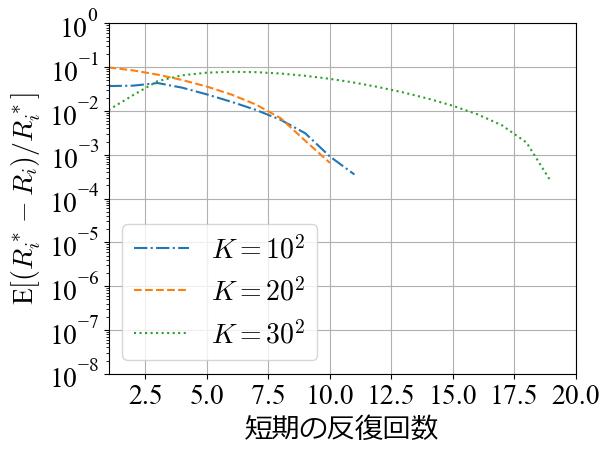

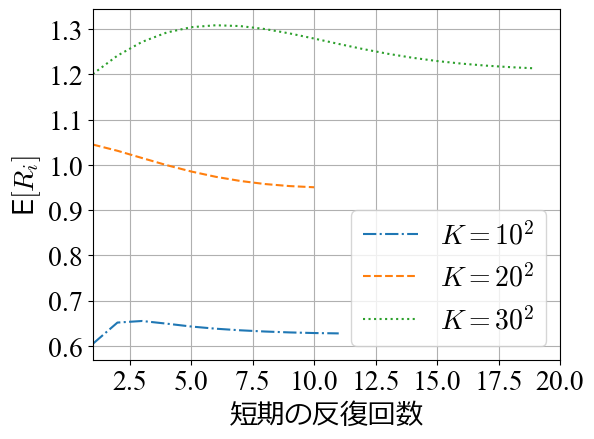

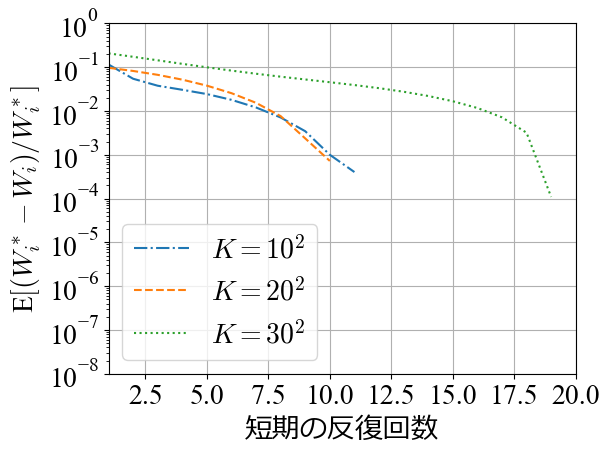

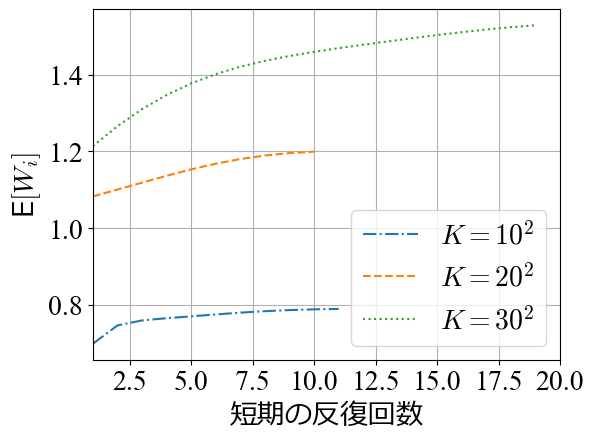

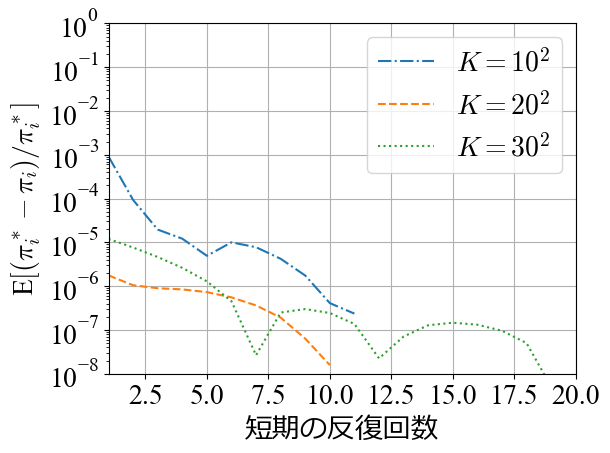

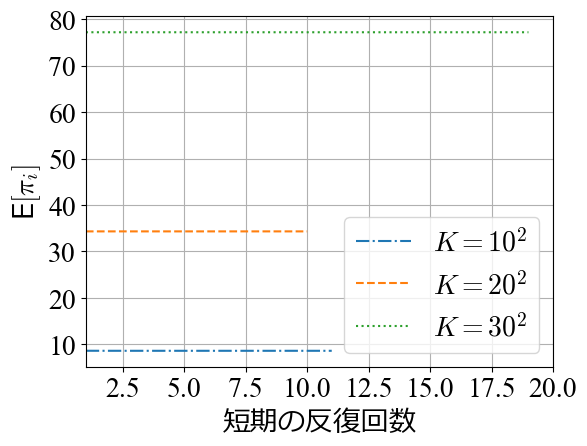

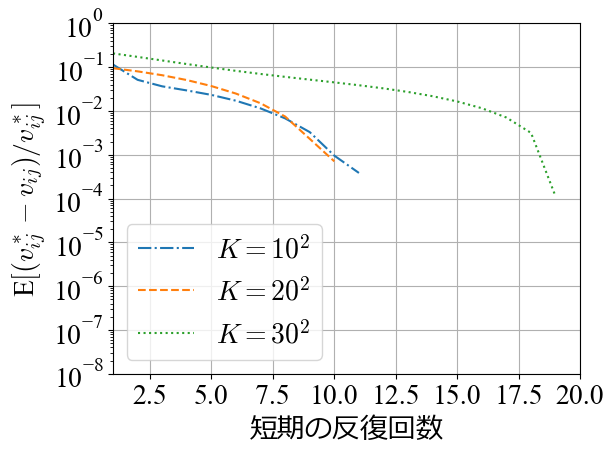

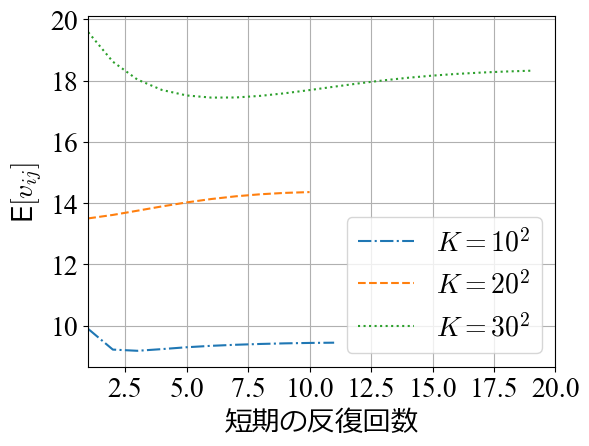

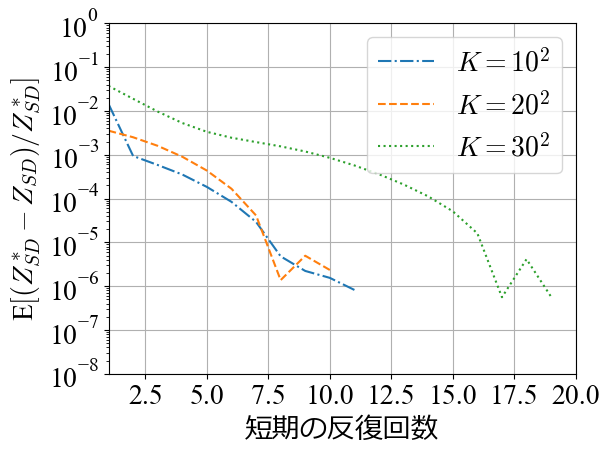

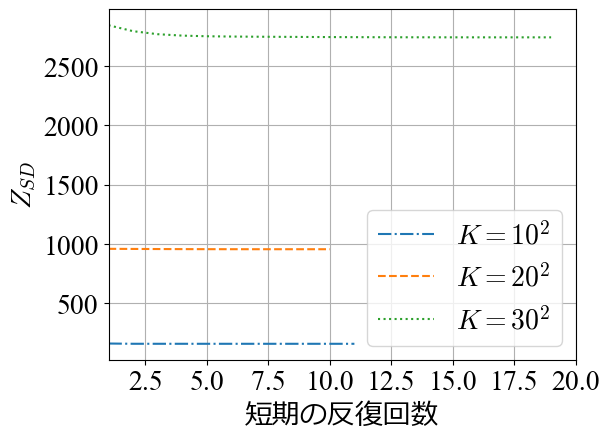

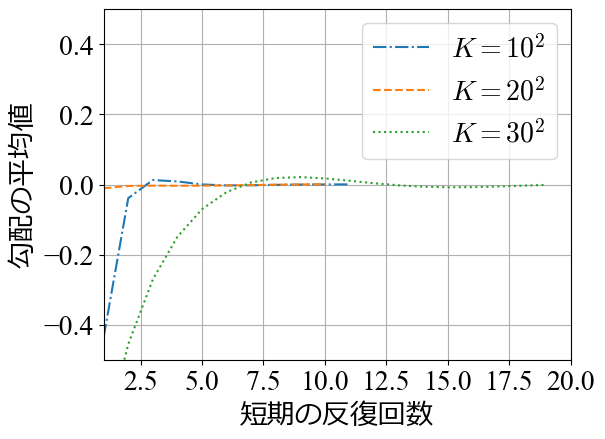

err_short=0.001, E=10, K=10^2
short_max_value: 3
jac: 0.002561911918656915
equ_R: 0.0019327776887058691
equ_W: 0.0019327776887057863
short_max_value: 3
jac: 0.002561911918656915
equ_R: 0.0019327776887058691
equ_W: 0.0019327776887057863
err_short=0.001, E=10, K=20^2
short_max_value: 3
jac: 0.0007302943124499732
equ_R: 0.0008022992106768919
equ_W: 0.0008022992106772397
short_max_value: 3
jac: 0.0007302943124499732
equ_R: 0.0008022992106768919
equ_W: 0.0008022992106772397
err_short=0.001, E=10, K=30^2
short_max_value: 10
jac: 0.007855650362233416
equ_R: 0.010500964971596739
equ_W: 0.010500964971609236
short_max_value: 10
jac: 0.007855650362233416
equ_R: 0.010500964971596739
equ_W: 0.010500964971609236
len(rel_path_list): 3


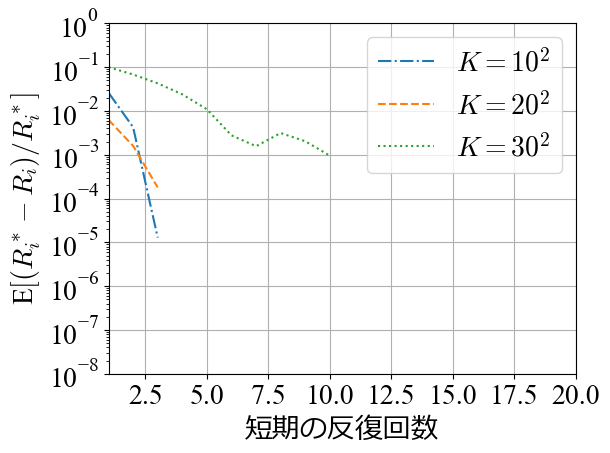

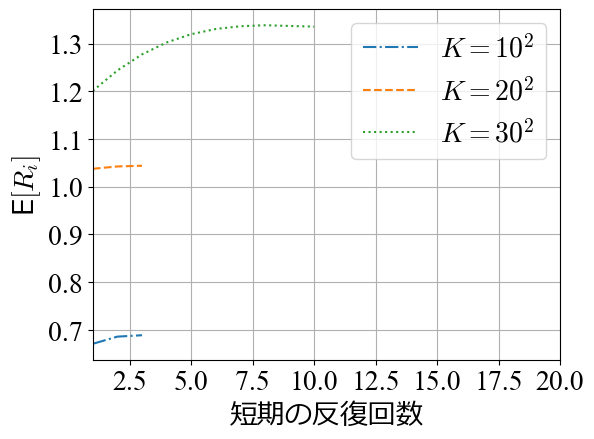

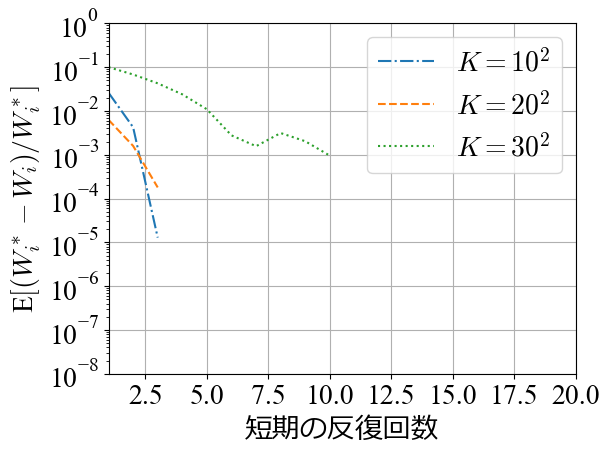

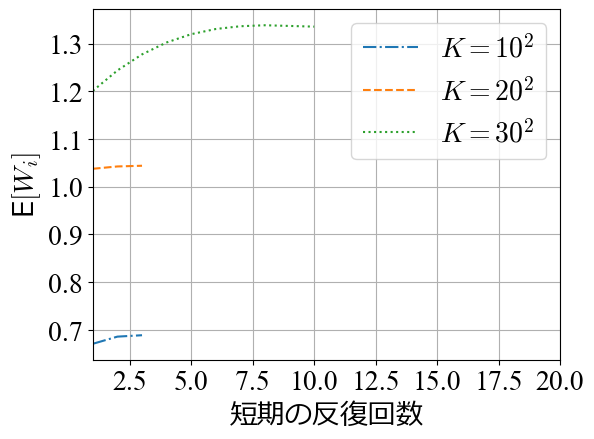

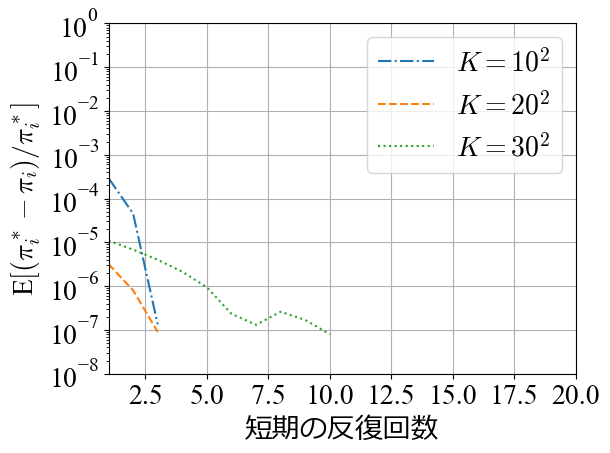

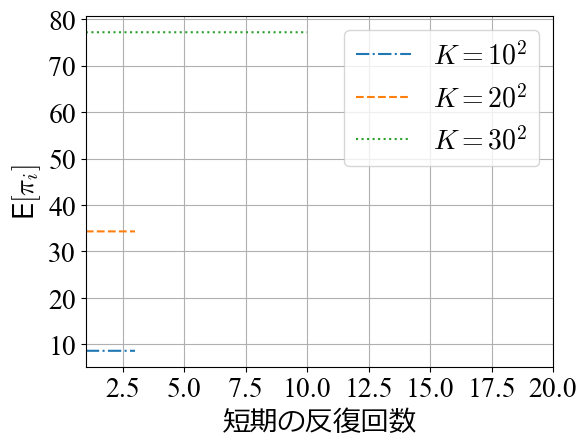

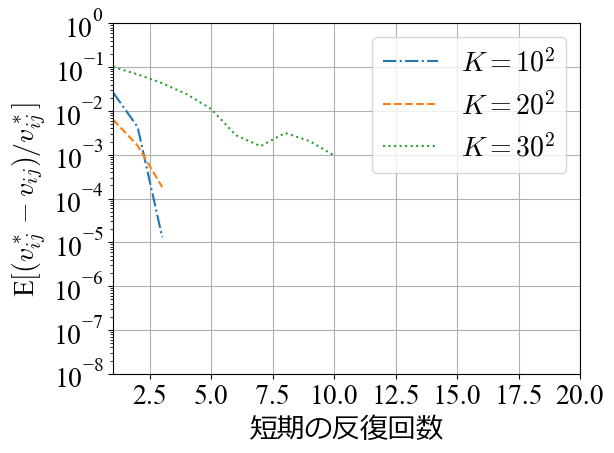

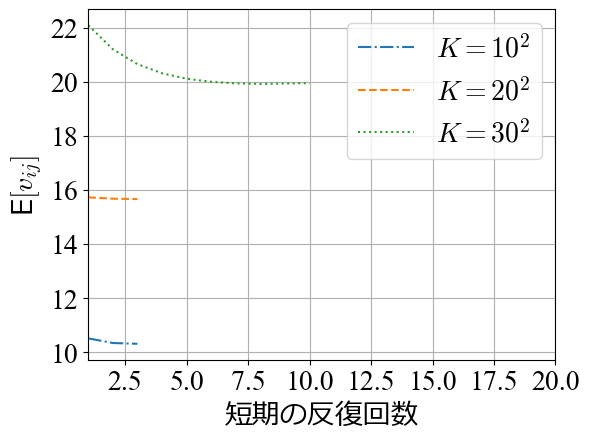

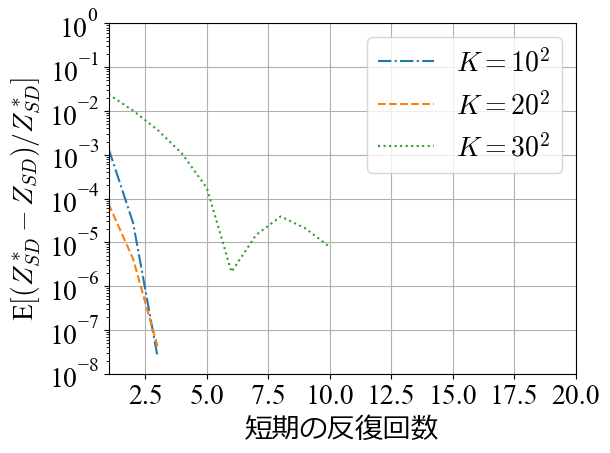

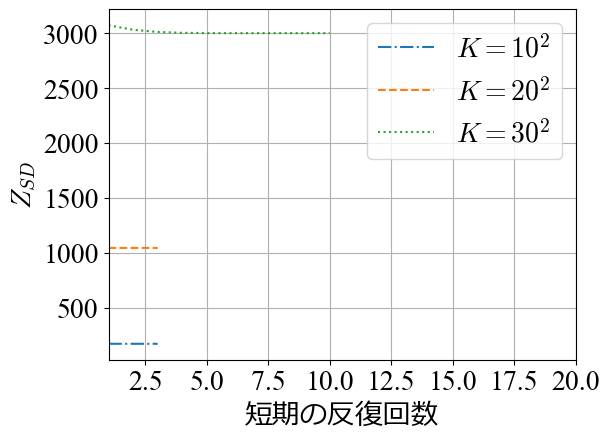

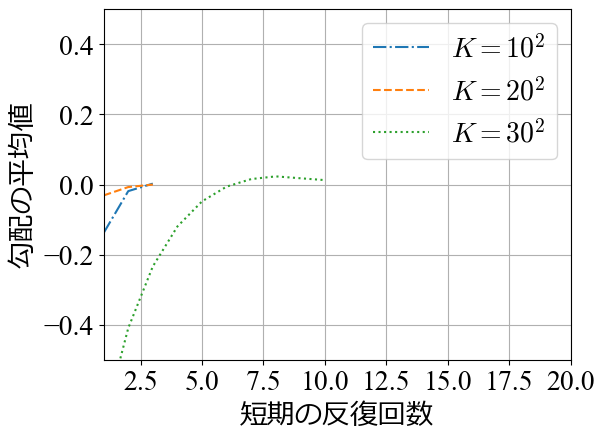

err_short=0.0001, E=5, K=10^2
short_max_value: 21
jac: -6.767574226794004e-05
equ_R: 4.443458735061366e-05
equ_W: -0.00022559715633348656
short_max_value: 21
jac: -6.767574226794004e-05
equ_R: 4.443458735061366e-05
equ_W: -0.00022559715633348656
err_short=0.0001, E=5, K=20^2
short_max_value: 22
jac: -0.00010179101477265844
equ_R: 0.00010691141030683711
equ_W: -0.0005139095492847032
short_max_value: 22
jac: -0.00010179101477265844
equ_R: 0.00010691141030683711
equ_W: -0.0005139095492847032
err_short=0.0001, E=5, K=30^2
short_max_value: 48
jac: -7.965421734603167e-05
equ_R: 0.00011089699645494666
equ_W: -0.0004801445414109836
short_max_value: 48
jac: -7.965421734603167e-05
equ_R: 0.00011089699645494666
equ_W: -0.0004801445414109836
len(rel_path_list): 3


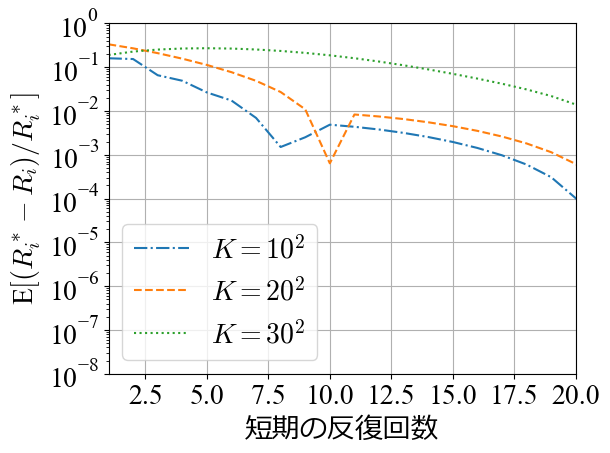

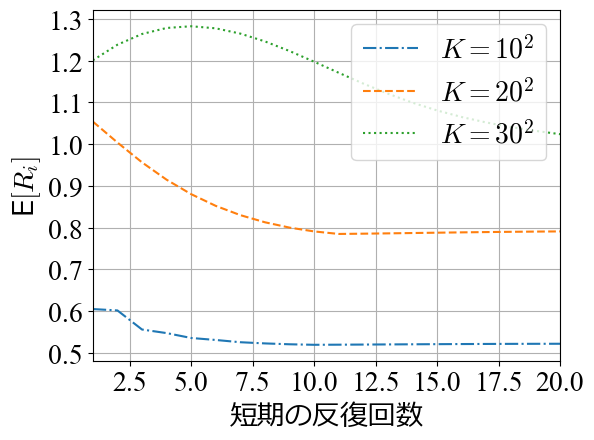

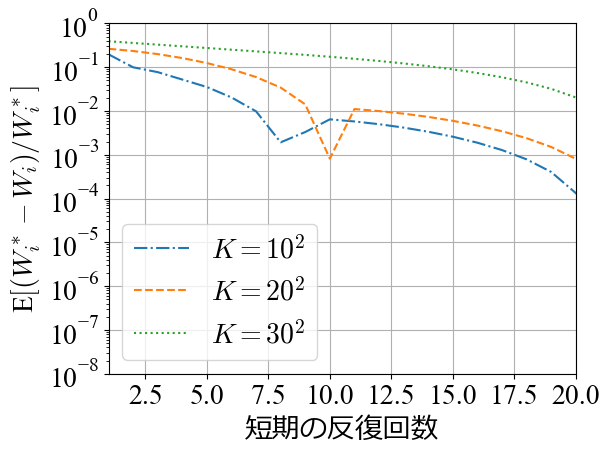

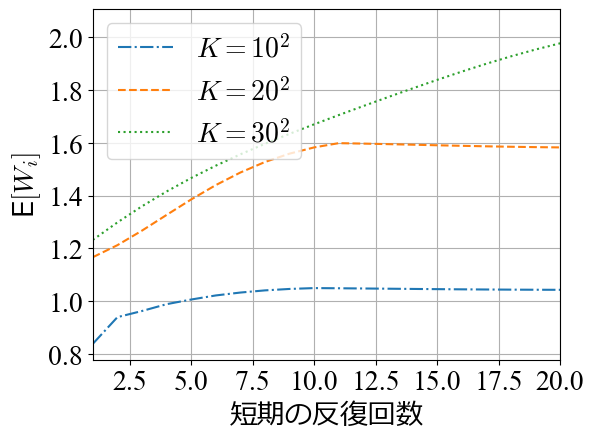

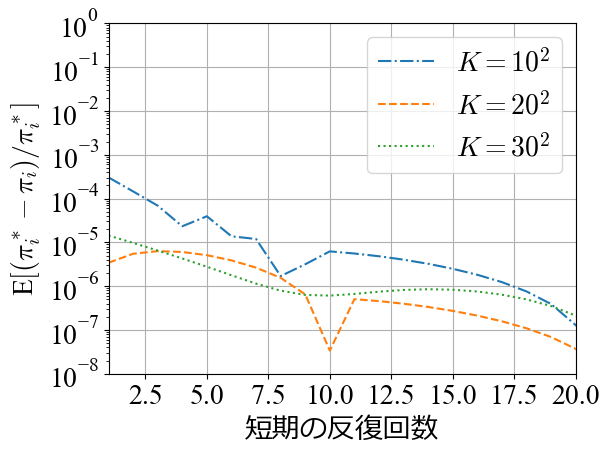

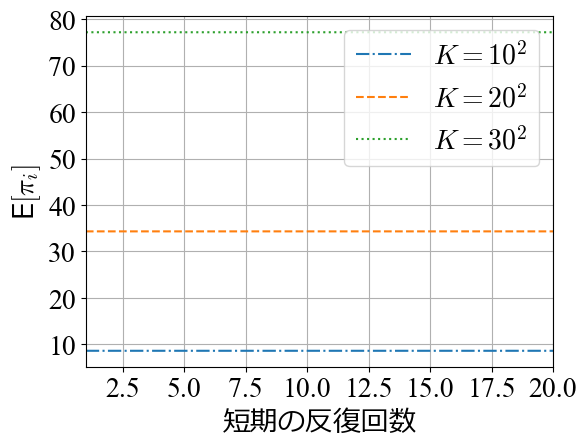

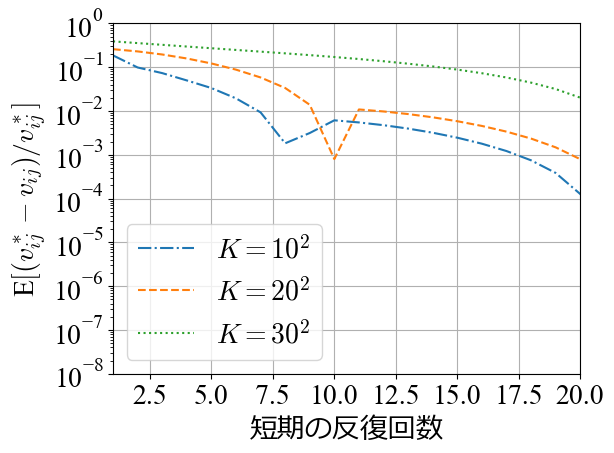

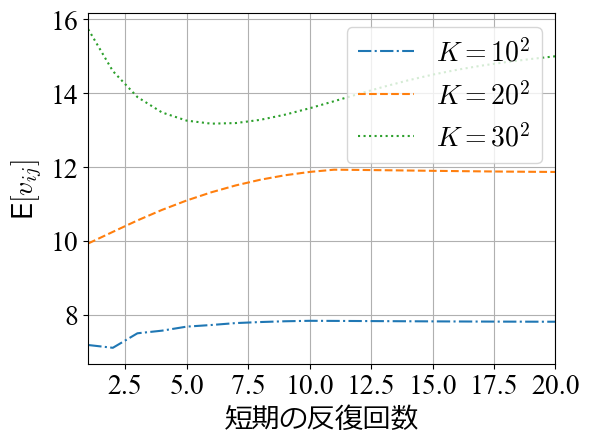

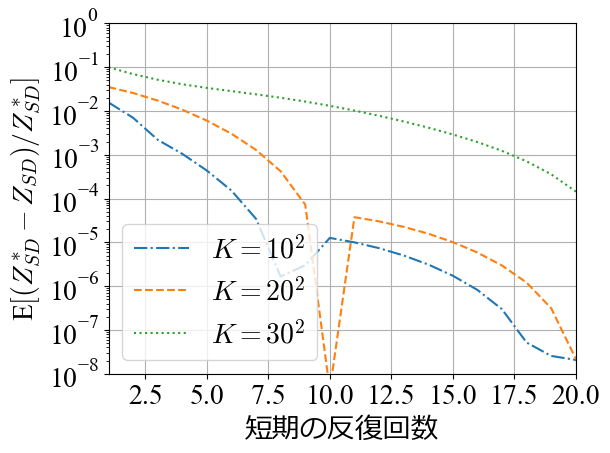

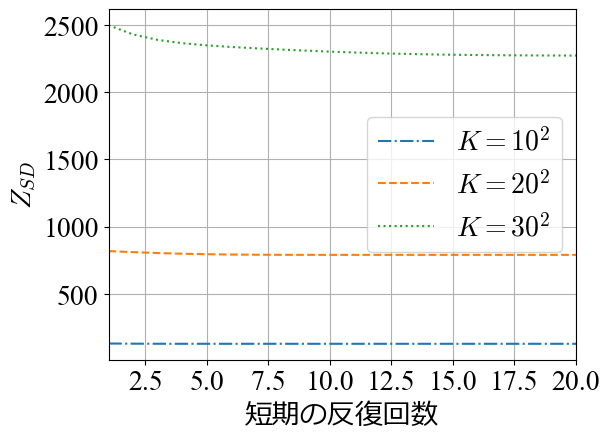

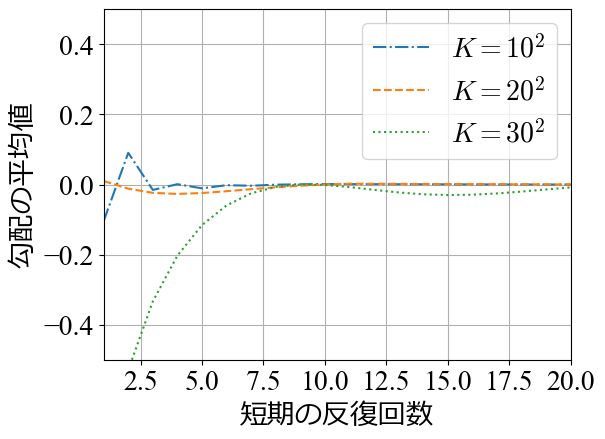

err_short=0.0001, E=8, K=10^2
short_max_value: 20
jac: -2.2376640411695368e-05
equ_R: 7.26634756787992e-05
equ_W: -0.00012358481105054805
short_max_value: 20
jac: -2.2376640411695368e-05
equ_R: 7.26634756787992e-05
equ_W: -0.00012358481105054805
err_short=0.0001, E=8, K=20^2
short_max_value: 19
jac: -2.6347132392023804e-05
equ_R: 0.00013245264577681863
equ_W: -0.00022187340622177476
short_max_value: 19
jac: -2.6347132392023804e-05
equ_R: 0.00013245264577681863
equ_W: -0.00022187340622177476
err_short=0.0001, E=8, K=30^2
short_max_value: 37
jac: -2.2697924996190093e-05
equ_R: 0.00012031835090677663
equ_W: -0.0001840503950933755
short_max_value: 37
jac: -2.2697924996190093e-05
equ_R: 0.00012031835090677663
equ_W: -0.0001840503950933755
len(rel_path_list): 3


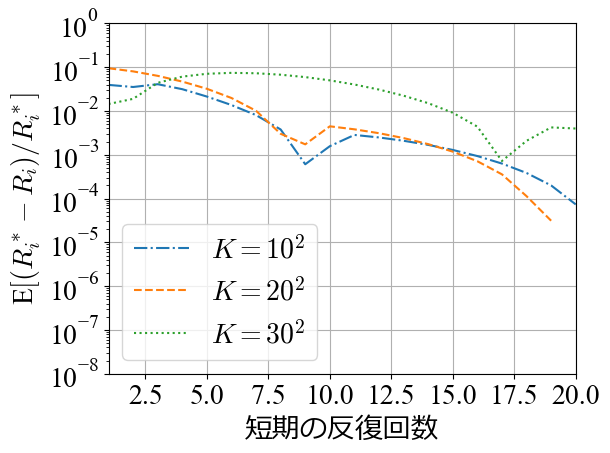

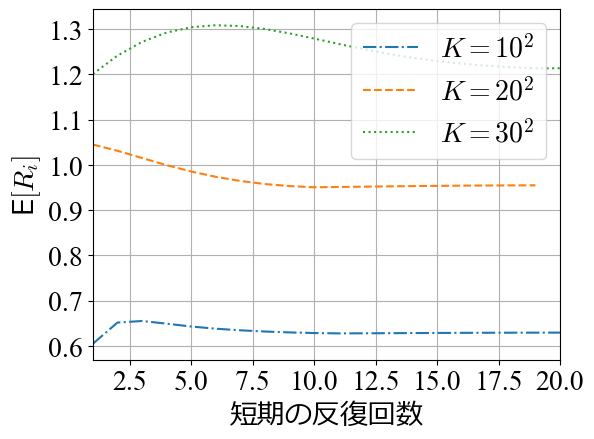

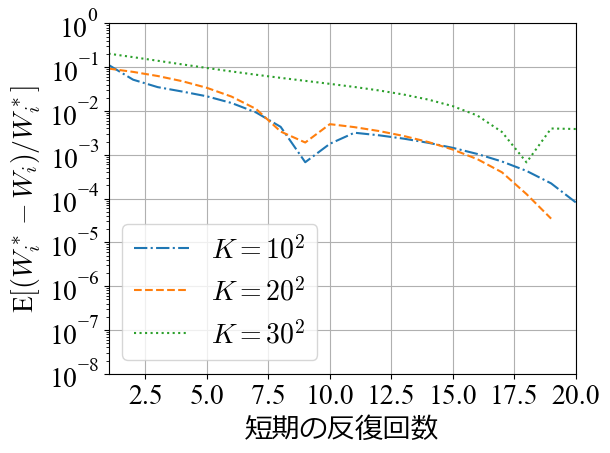

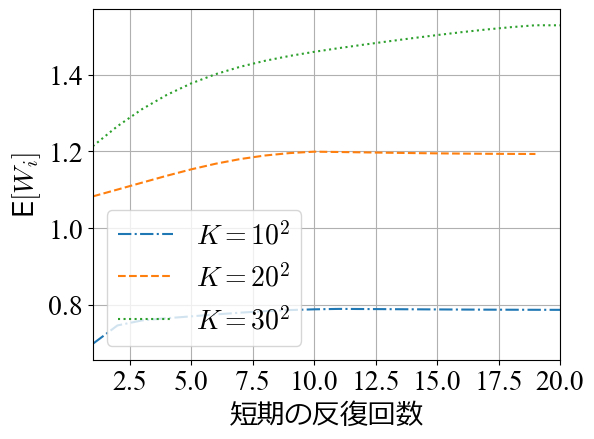

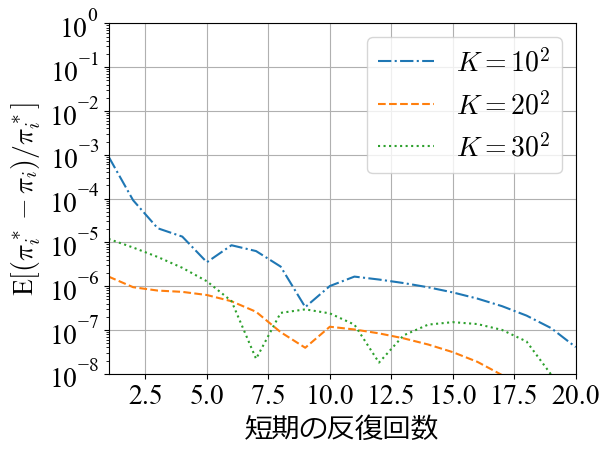

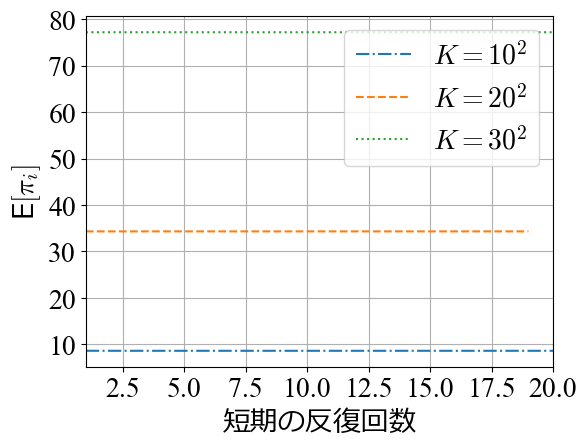

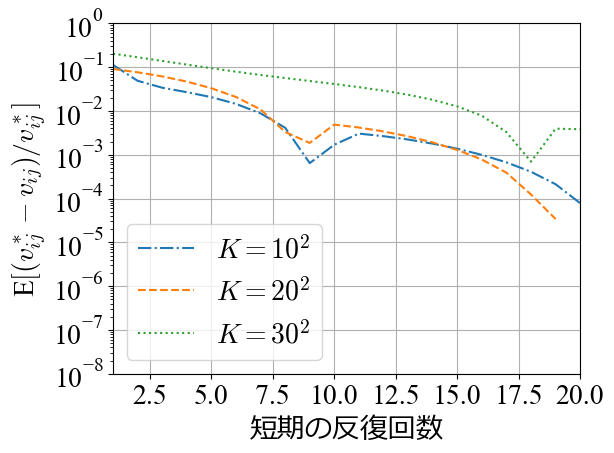

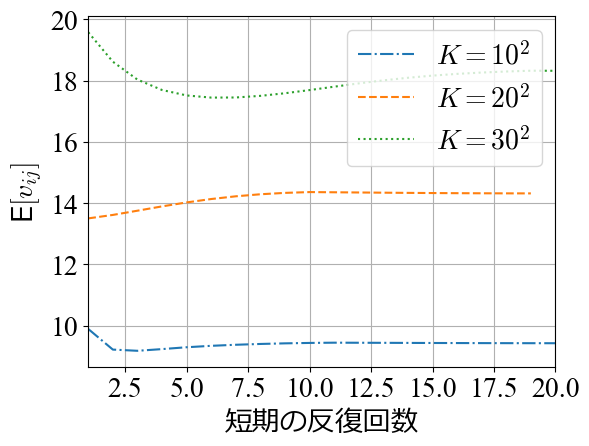

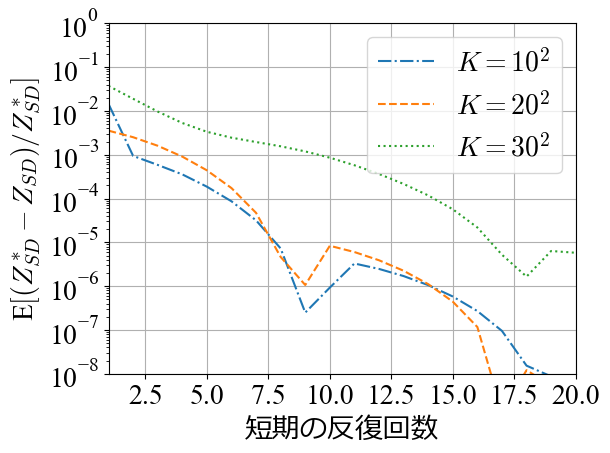

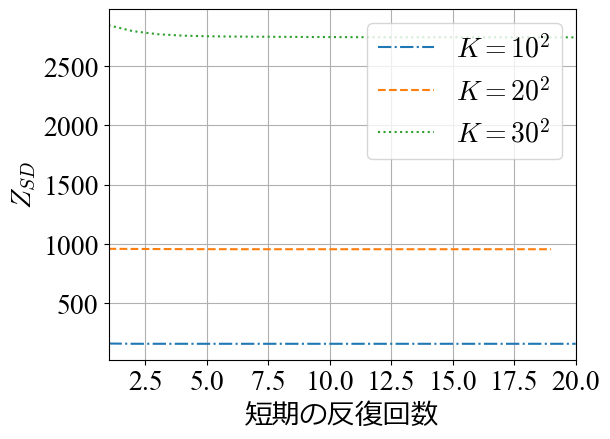

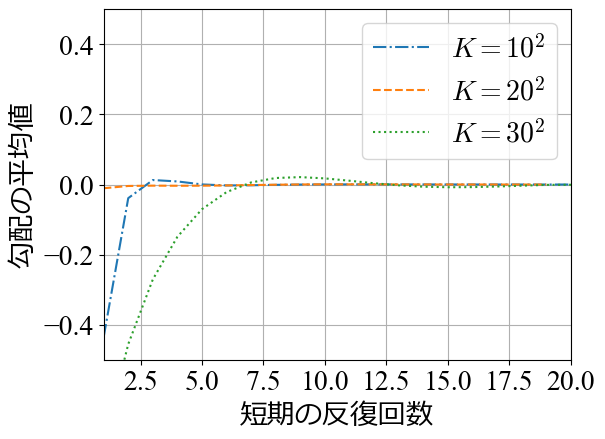

err_short=0.0001, E=10, K=10^2
short_max_value: 3
jac: 0.002561911918656915
equ_R: 0.0019327776887058691
equ_W: 0.0019327776887057863
short_max_value: 3
jac: 0.002561911918656915
equ_R: 0.0019327776887058691
equ_W: 0.0019327776887057863
err_short=0.0001, E=10, K=20^2
short_max_value: 4
jac: 0.0003028813550574642
equ_R: 0.0003448266642033373
equ_W: 0.0003448266642034528
short_max_value: 4
jac: 0.0003028813550574642
equ_R: 0.0003448266642033373
equ_W: 0.0003448266642034528
err_short=0.0001, E=10, K=30^2
short_max_value: 15
jac: -0.000828537988804541
equ_R: -0.0011021231985715856
equ_W: -0.0011021231985647649
short_max_value: 15
jac: -0.000828537988804541
equ_R: -0.0011021231985715856
equ_W: -0.0011021231985647649
len(rel_path_list): 3


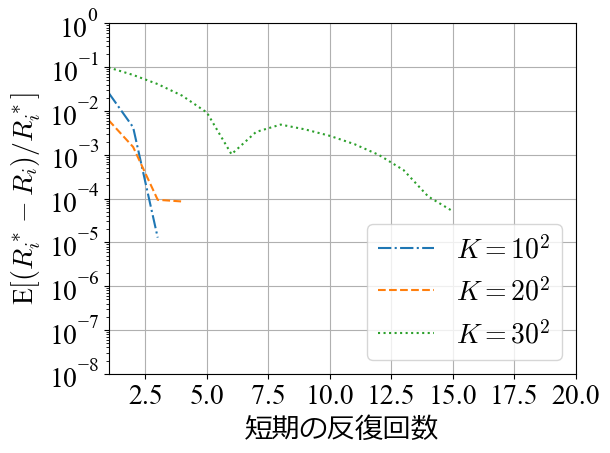

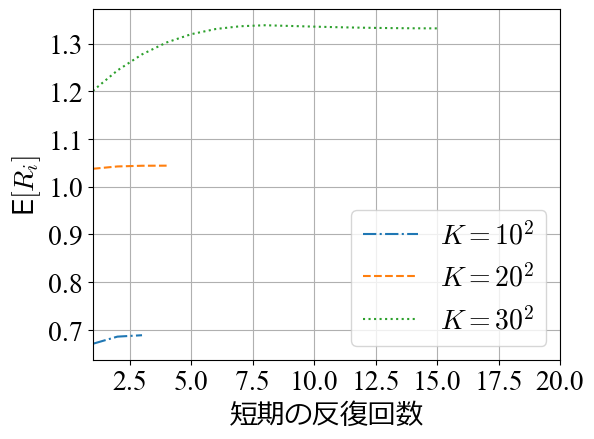

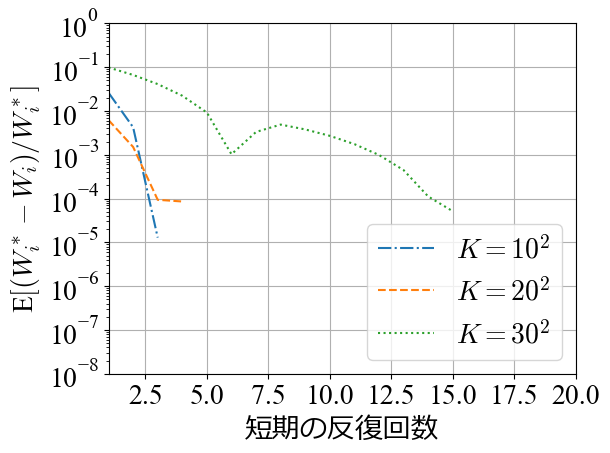

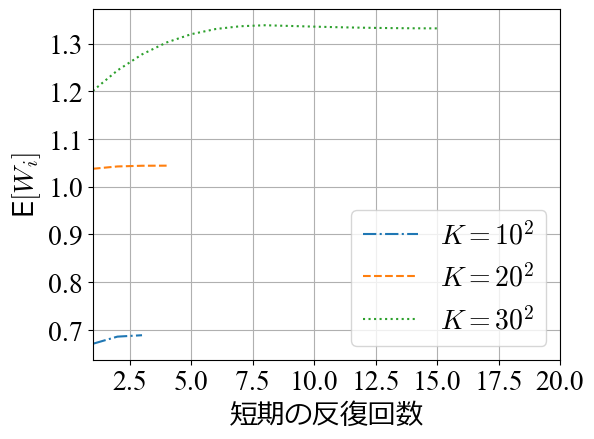

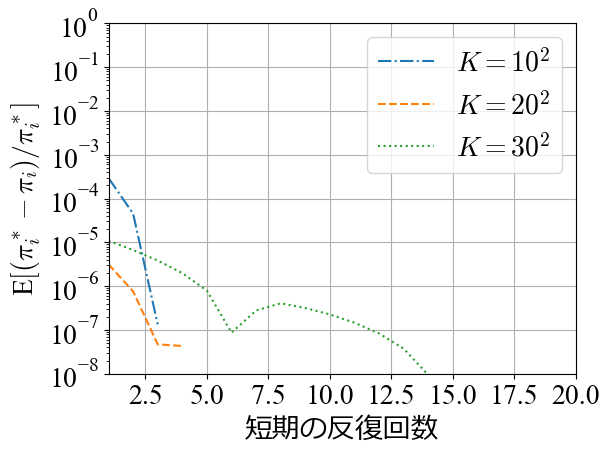

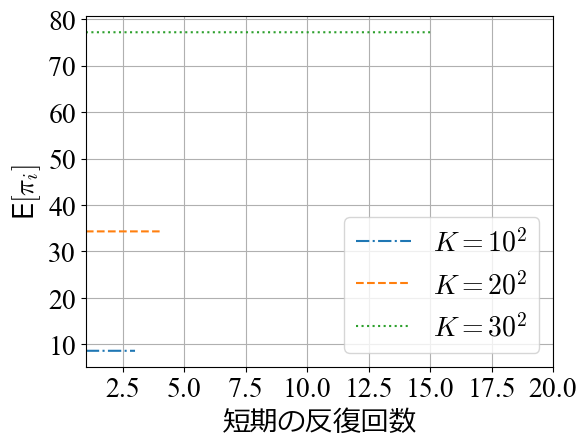

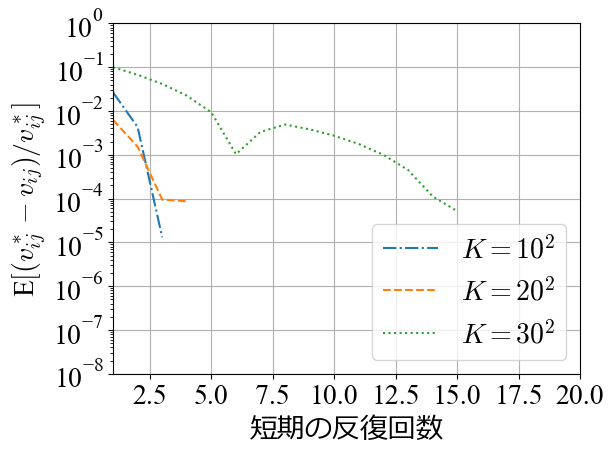

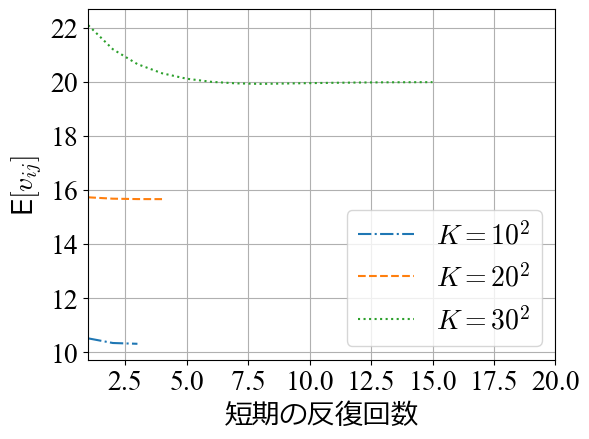

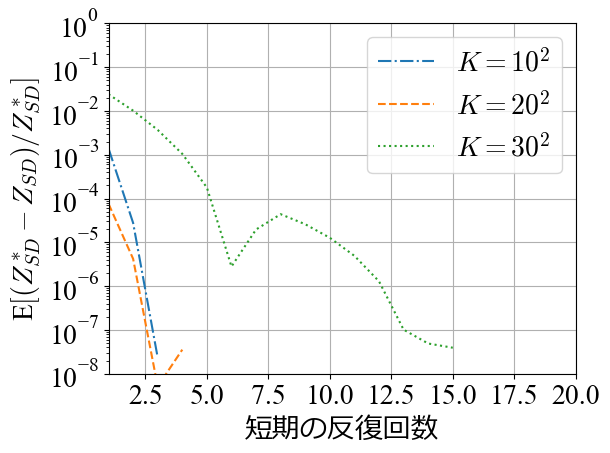

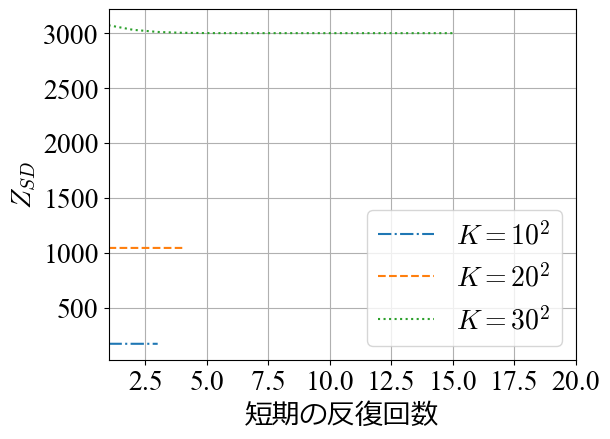

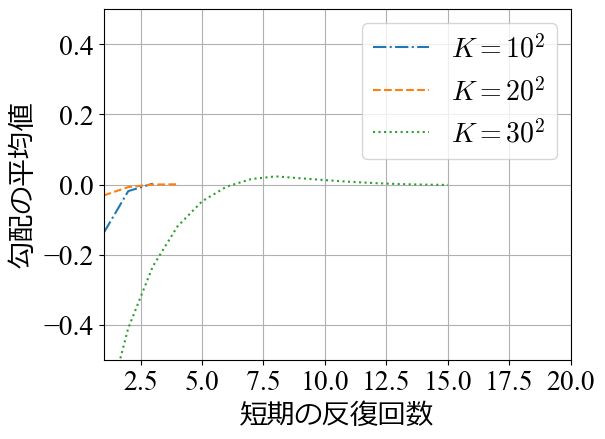

err_short=1e-05, E=5, K=10^2
short_max_value: 31
jac: 4.149552840635152e-06
equ_R: -2.6073649098424622e-06
equ_W: 1.4723546498293148e-05
short_max_value: 31
jac: 4.149552840635152e-06
equ_R: -2.6073649098424622e-06
equ_W: 1.4723546498293148e-05
err_short=1e-05, E=5, K=20^2
short_max_value: 33
jac: 4.845060175947345e-06
equ_R: -4.6077785650973845e-06
equ_W: 2.8145311948499874e-05
short_max_value: 33
jac: 4.845060175947345e-06
equ_R: -4.6077785650973845e-06
equ_W: 2.8145311948499874e-05
err_short=1e-05, E=5, K=30^2
short_max_value: 71
jac: 2.1149775309973437e-06
equ_R: -2.1604245504318805e-06
equ_W: 2.1910579438807288e-05
short_max_value: 71
jac: 2.1149775309973437e-06
equ_R: -2.1604245504318805e-06
equ_W: 2.1910579438807288e-05
len(rel_path_list): 3


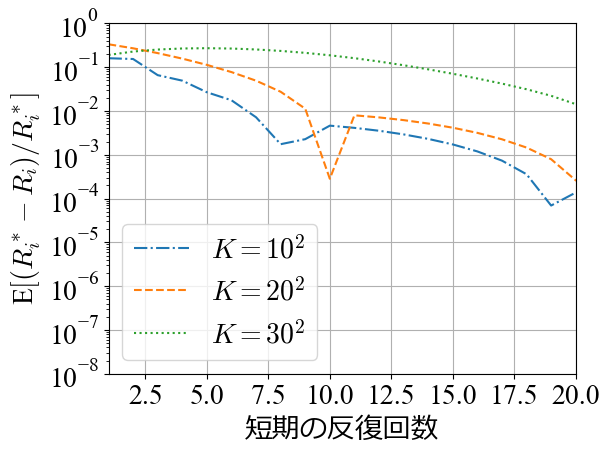

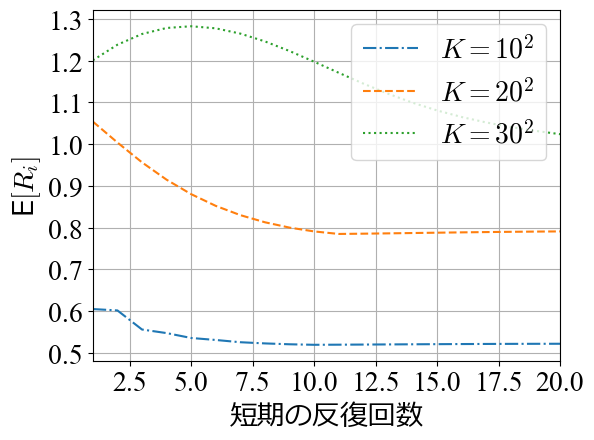

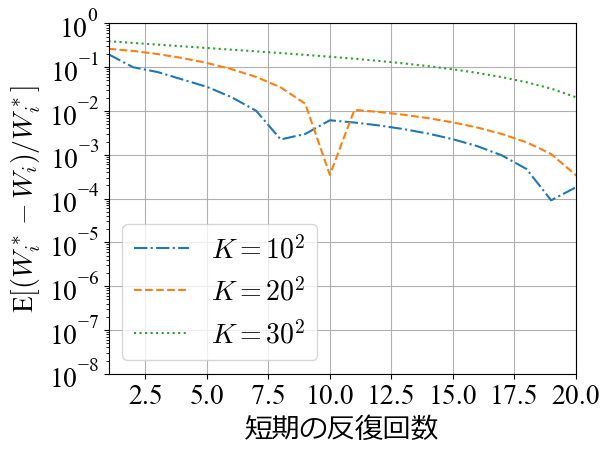

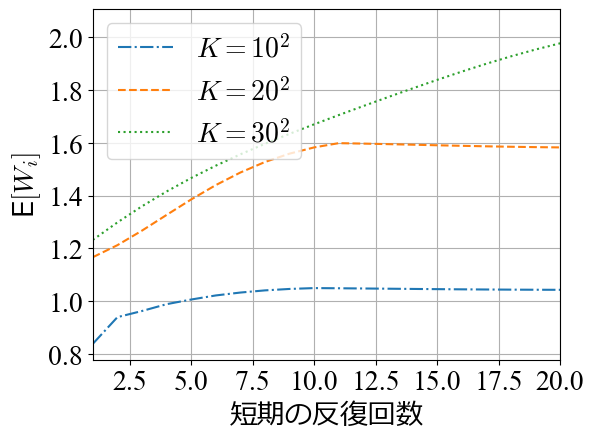

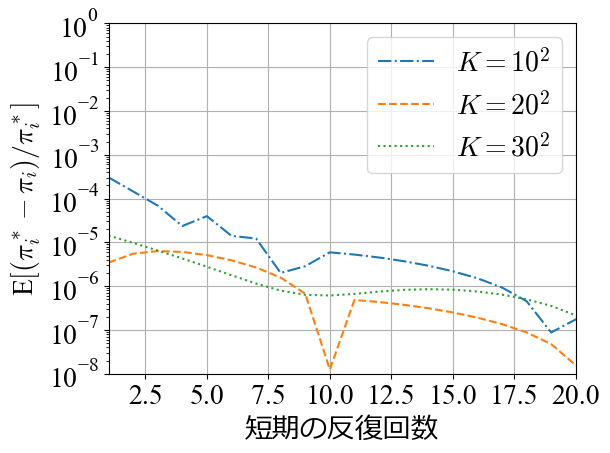

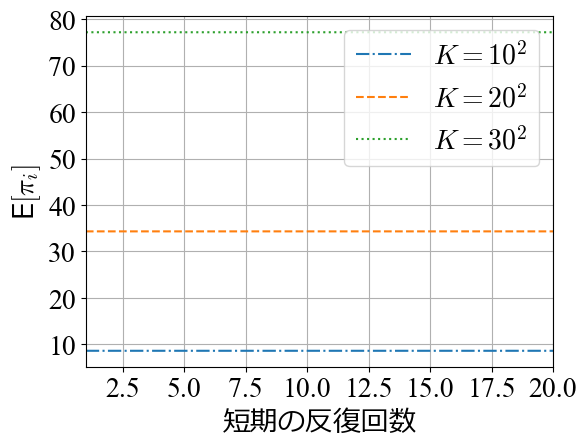

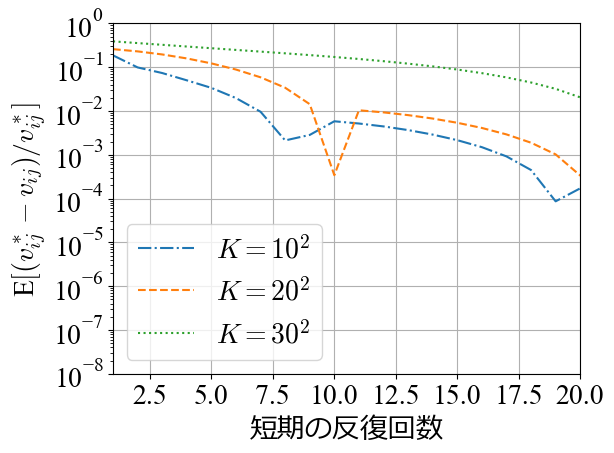

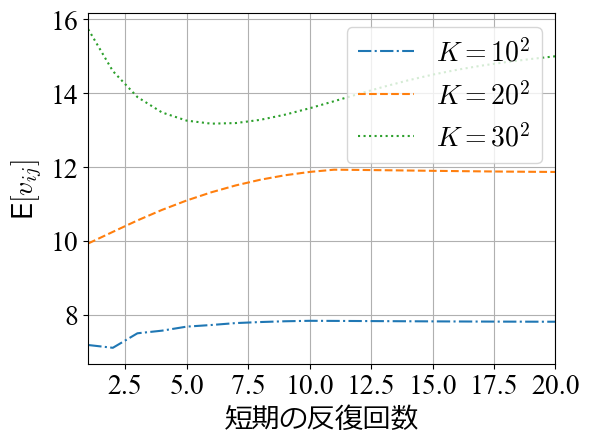

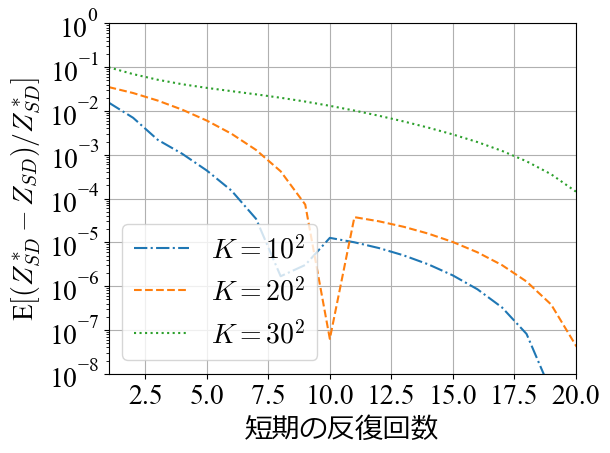

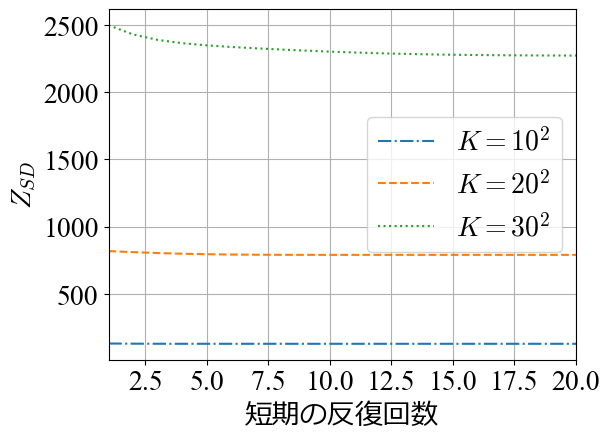

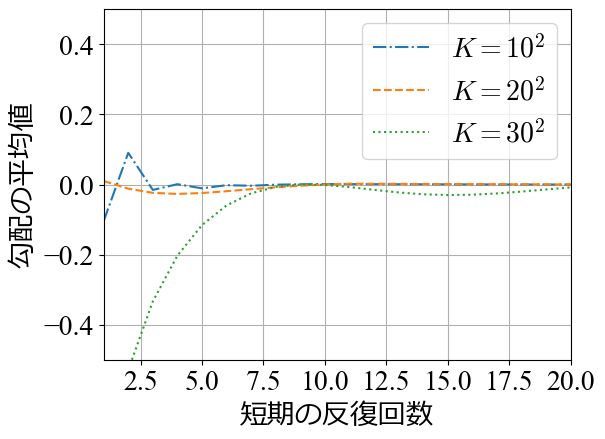

err_short=1e-05, E=8, K=10^2
short_max_value: 29
jac: 6.184023700954748e-07
equ_R: -1.928455024849842e-06
equ_W: 3.6734064884553807e-06
short_max_value: 29
jac: 6.184023700954748e-07
equ_R: -1.928455024849842e-06
equ_W: 3.6734064884553807e-06
err_short=1e-05, E=8, K=20^2
short_max_value: 27
jac: 1.488833648619693e-06
equ_R: -7.1578241618575524e-06
equ_W: 1.3479019107055957e-05
short_max_value: 27
jac: 1.488833648619693e-06
equ_R: -7.1578241618575524e-06
equ_W: 1.3479019107055957e-05
err_short=1e-05, E=8, K=30^2
short_max_value: 37
jac: -2.2697924996190093e-05
equ_R: 0.00012031835090677663
equ_W: -0.0001840503950933755
short_max_value: 37
jac: -2.2697924996190093e-05
equ_R: 0.00012031835090677663
equ_W: -0.0001840503950933755
len(rel_path_list): 3


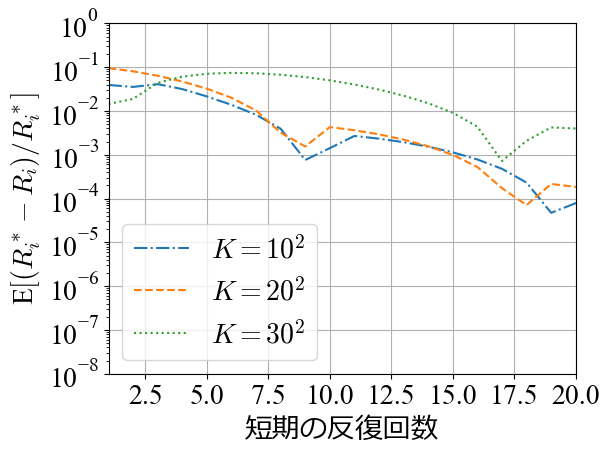

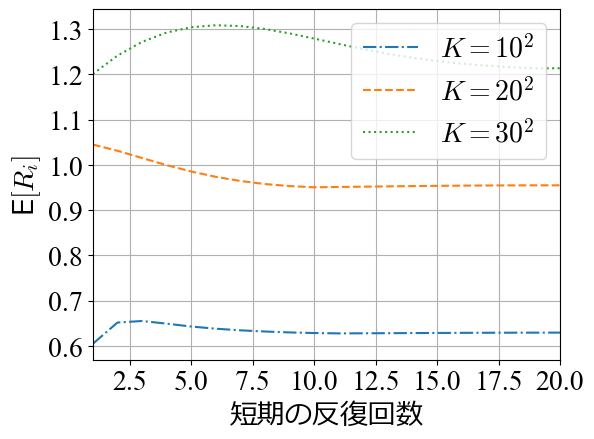

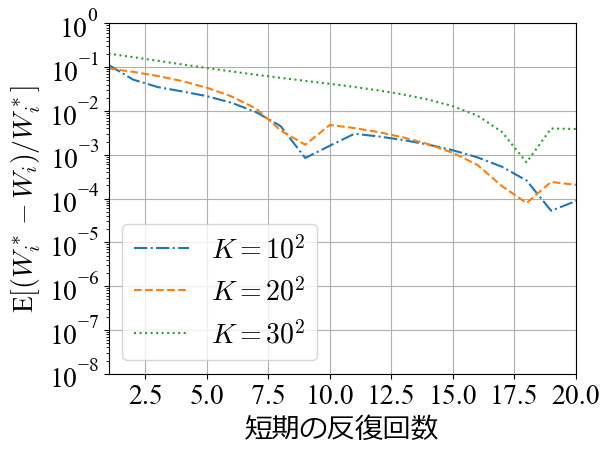

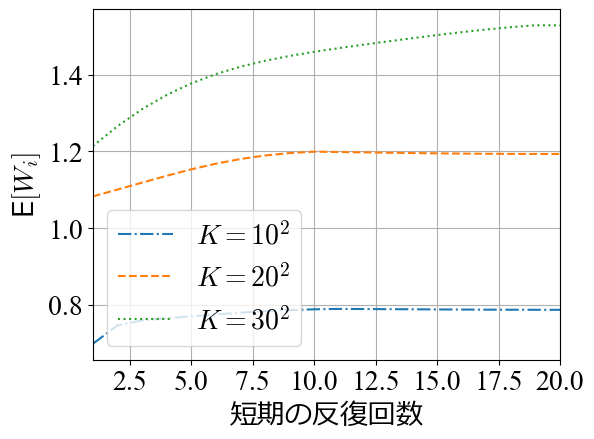

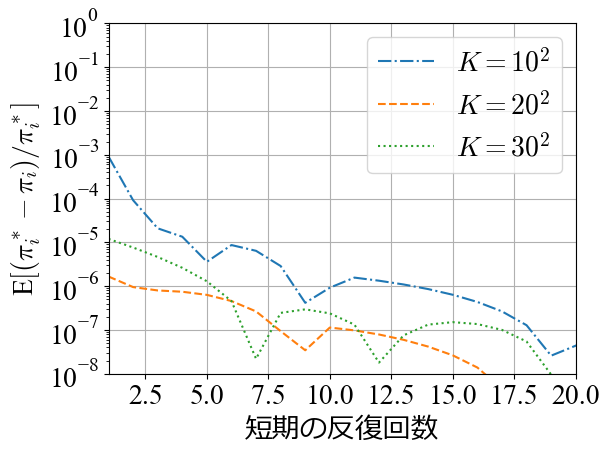

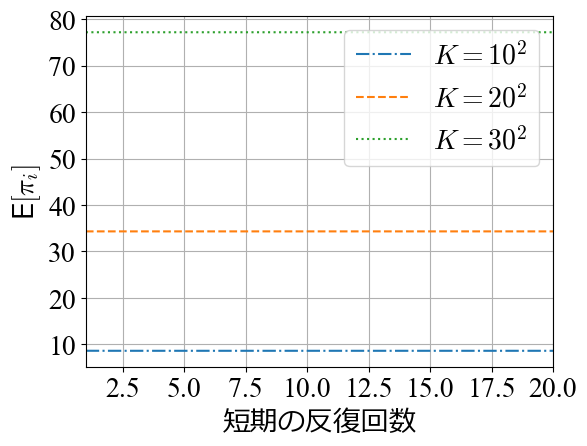

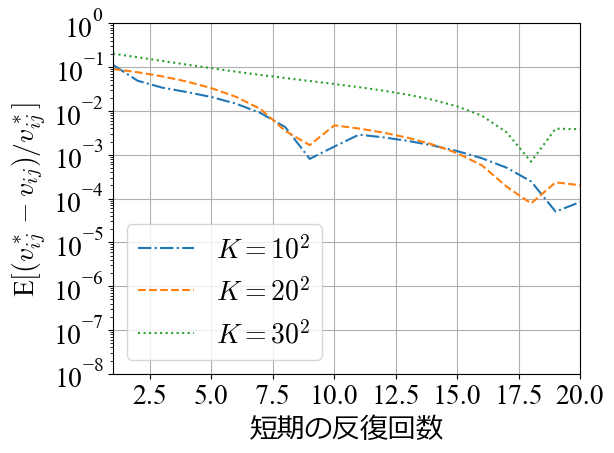

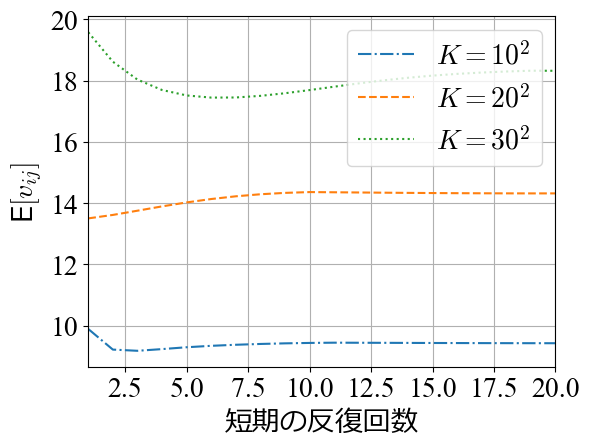

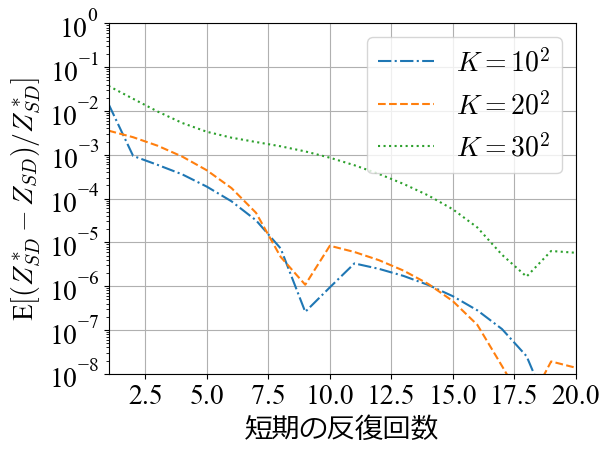

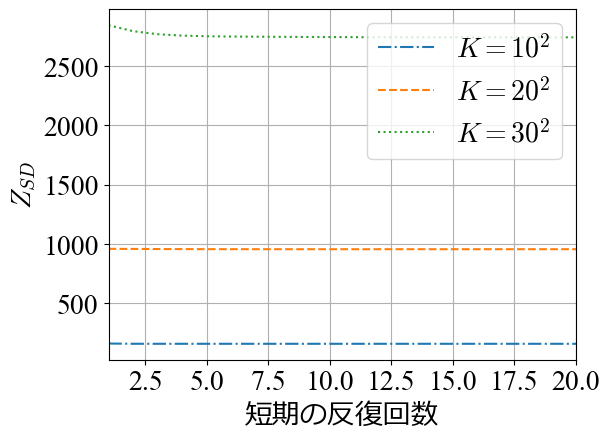

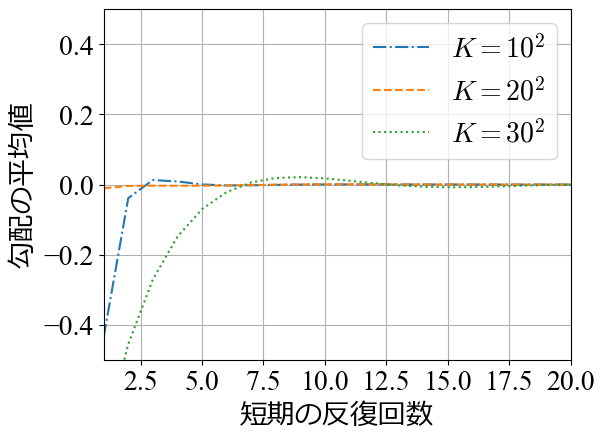

err_short=1e-05, E=10, K=10^2
short_max_value: 6
jac: -0.00012307460475272826
equ_R: -4.9529869831842655e-05
equ_W: -4.9529869832150514e-05
short_max_value: 6
jac: -0.00012307460475272826
equ_R: -4.9529869831842655e-05
equ_W: -4.9529869832150514e-05
err_short=1e-05, E=10, K=20^2
short_max_value: 7
jac: -2.0804023300129796e-05
equ_R: -1.2045123097756134e-05
equ_W: -1.2045123097985278e-05
short_max_value: 7
jac: -2.0804023300129796e-05
equ_R: -1.2045123097756134e-05
equ_W: -1.2045123097985278e-05
err_short=1e-05, E=10, K=30^2
short_max_value: 21
jac: 5.0299049145365885e-05
equ_R: 6.958127370702488e-05
equ_W: 6.958127370949575e-05
short_max_value: 21
jac: 5.0299049145365885e-05
equ_R: 6.958127370702488e-05
equ_W: 6.958127370949575e-05
len(rel_path_list): 3


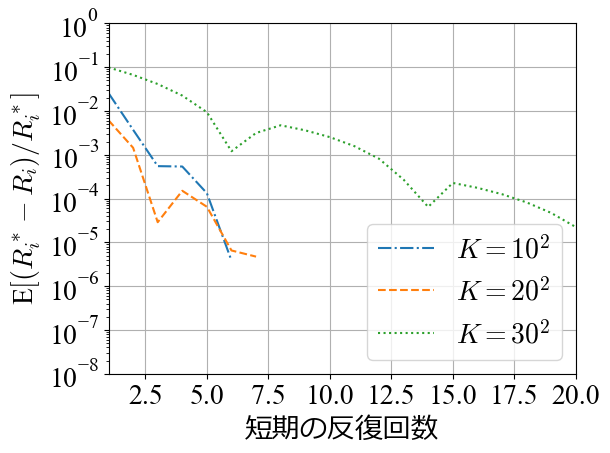

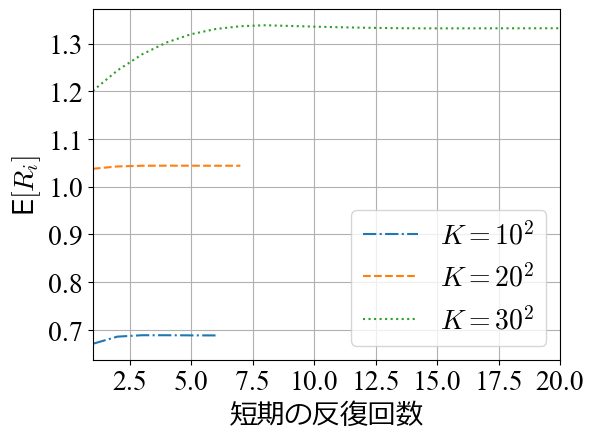

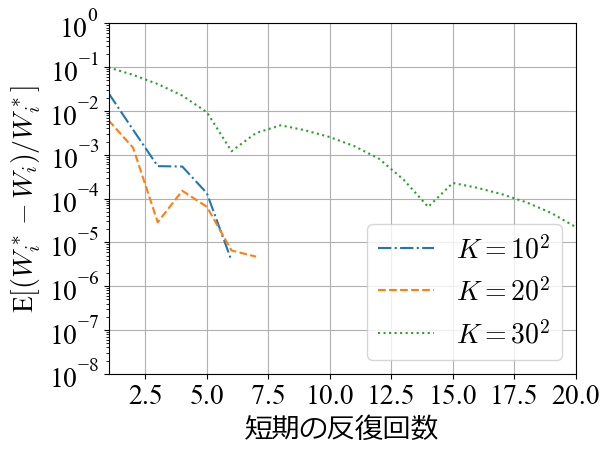

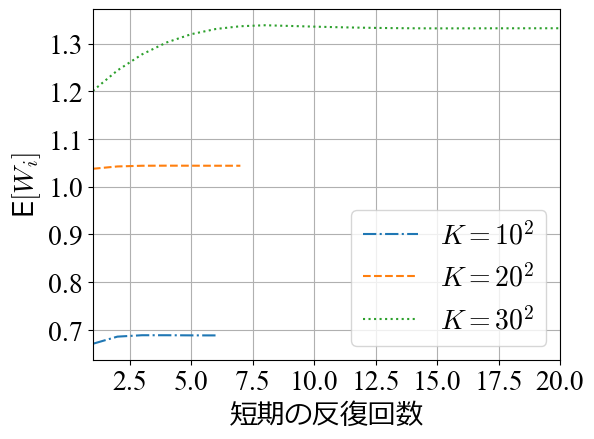

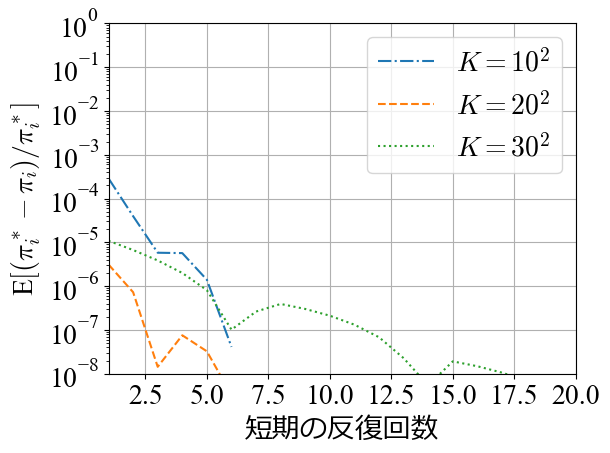

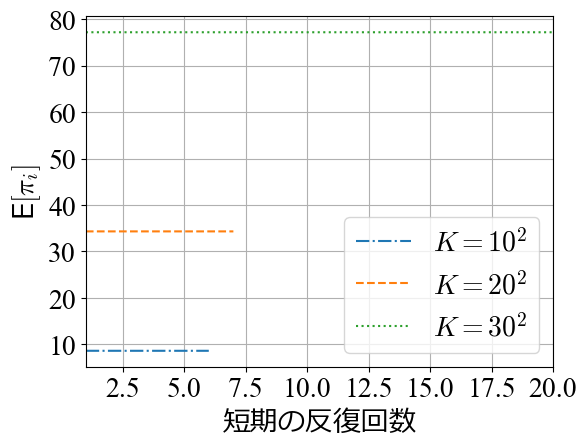

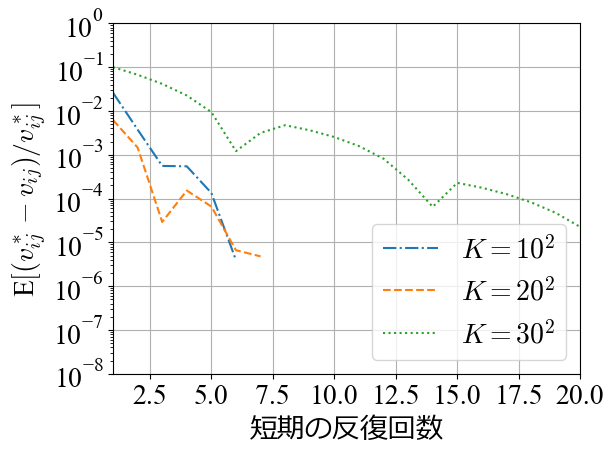

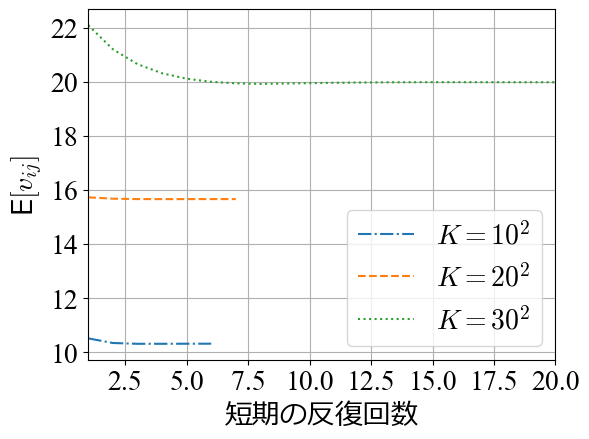

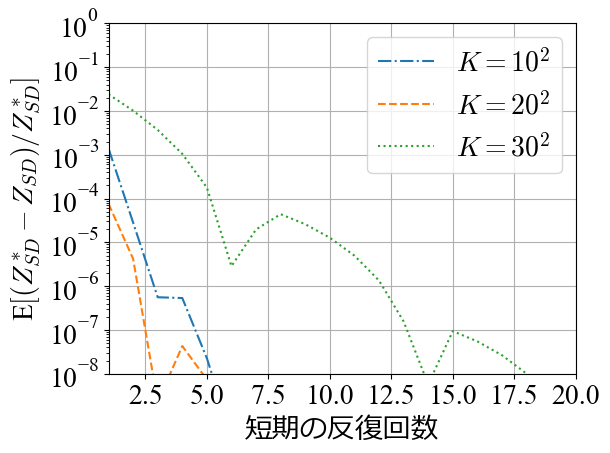

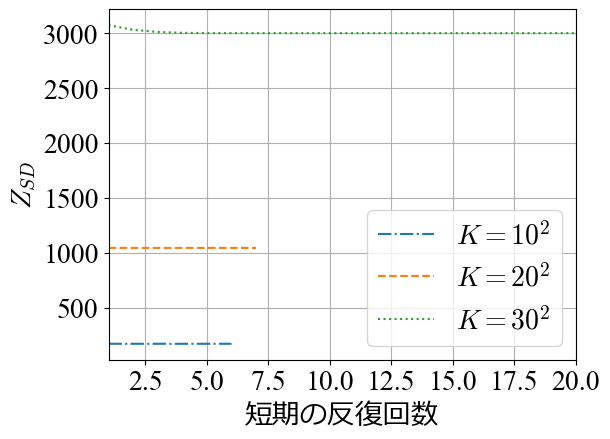

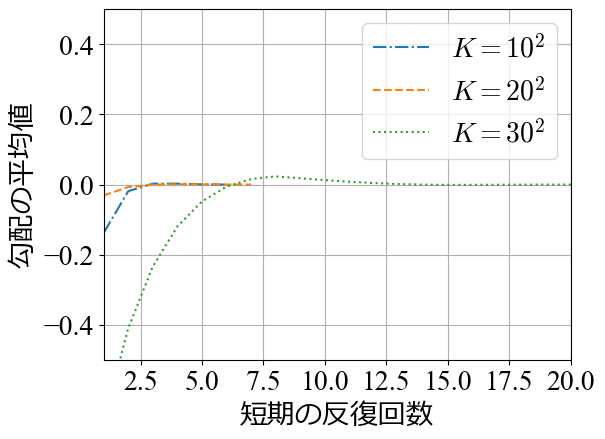

In [3]:
E_list = [5]
Col_list = [10, 20, 30]
err_short_list = [1e-5]
R_plot_list = []
W_plot_list = []
pi_plot_list = []
v_plot_list = []
Z_plot_list = []
rel_path_list = []
for err_short in err_short_list:
    for E in E_list:
        for Col in Col_list:
            
            print("="*40)
            print(f"err_short={err_short}, E={E}, K={Col}^2")
    
            # Scaling * tが格子の最小距離となる。
            Scaling = 30 / Col
            alter_T_num = 0.5
    
            city_network = lattice.make_lattice(Col)
    
            # 通勤費用パラメータ
            t = 0.1
    
            # 距離抵抗パラメータ
            tau = 0.01

            K = Col * Col
        
            M = 0.1 * K
            N = 0.1 * K
    
            dF_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
                fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_F.xlsx')
            dH_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
                fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_H.xlsx')
    
            m_fixed = np.array(dF_long['m'].tolist())
            n_fixed = np.array(dH_long['n'].tolist()).reshape(K, K)
    
            # m_per = M / K
            # m_fixed = np.array([m_per] * K)
            # n_fixed = np.full((K, K), N / (K * K))
    
            # 総土地供給量
            S_total = K
            S_bar = S_total / K
    
            Coordinate_Data = \
            np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
                       city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
            distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))
    
            theta_firm = 5.0
            theta_house = 5.0
    
            alpha_1 = 0.4
            alpha_2 = 0.4
            beta_1 = 0.4
            beta_2 = 0.4
    
            L = 0.2
            eta = 1.2
            p_proj = 1e-3
    
            RW_ini = 1.0
            RW_proj = 1e-3
            
            method = "FISTA"
            dic = "Scaling=30divCol"
            long = "ichiyou"
            
            #パラメータ設定
            prm = exp_Short_FISTA.Parameter(
                        Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
                        theta_firm, theta_house, E, RW_proj, alter_T_num,
                        alpha_1, alpha_2, beta_1, beta_2, M, N)
            
            algprm = exp_Short_FISTA.Algo_Parameter(L, eta, p_proj)
            short = exp_Short_FISTA.Short(prm, algprm)
            
            alter_T = alter_T_num * Scaling * t
            # print("T:", np.maximum(alter_T, prm.T))
    
            #step.1-1
            R_true, W_true, iteration, err_R, err_W, err_v, err_pi, err_obj, grad_mean, \
            R_list, W_list, pi_list, v_list, Z_list =\
            short.short_solve(RW_ini, m_fixed, n_fixed, err_short, 
                              R_corr=None, W_corr=None, pi_corr=None, v_corr=None, obj_corr=None,
                              short_itr=10001, rel=0)
    
            pi_true = short.pi(R_true, W_true, m_fixed)
            v_true = short.v(R_true, W_true)
            
            RW_true = np.concatenate((R_true, W_true))
            obj_true = short.Z_SD(RW_true, m_fixed, n_fixed)
            
            exp_kakunou.short_kakunou_true(R_true, W_true, pi_true, v_true, prm, algprm, long, method, err_short, dic)
    
            #step.1-3
            R, W, iteration, err_R, err_W, err_v, err_pi, err_obj, grad_mean, \
            R_list, W_list, pi_list, v_list, Z_list =\
            short.short_solve(RW_ini, m_fixed, n_fixed, err_short, 
                              R_true, W_true, pi_true, v_true, obj_true, 
                              short_itr=10001, rel=1)
            
            #step.1-4
            rel_path = exp_kakunou.short_kakunou_rel\
            (iteration, err_R, err_W, err_v, err_pi, err_obj, grad_mean, prm, algprm, long, method, err_short, dic)
    
            rel_path_list.append(rel_path)
            
            R_plot_list.append(R_list)
            W_plot_list.append(W_list)
            pi_plot_list.append(pi_list)
            v_plot_list.append(v_list)
            Z_plot_list.append(Z_list)
    
        #step.2
        print("len(rel_path_list):", len(rel_path_list))
        exp_qseplot.rel_plot(R_plot_list, W_plot_list, pi_plot_list, v_plot_list, Z_plot_list, 
                             rel_path_list, Col_list, prm, algprm, long, method, err_short, dic)
        
        rel_path_list.clear()
        R_plot_list.clear()
        W_plot_list.clear()
        pi_plot_list.clear()
        v_plot_list.clear()
        Z_plot_list.clear()

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as spsp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.font_manager import FontProperties
import csv
import os

E_list = [8, 10]
for E in E_list:
    print("="*40)
    print("E=f'{E}':", E)

    dF_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'short/FISTA/long_shuseki/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/rel_err/jikken.xlsx')
    dF_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'short/FISTA/long_shuseki/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/rel_err/jikken.xlsx')
    dF_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
        fr'short/FISTA/long_shuseki/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/rel_err/jikken.xlsx')
    
    # dF_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    #     fr'short/FISTA/long_ichiyou/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/rel_err/jikken.xlsx')
    # dF_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    #     fr'short/FISTA/long_ichiyou/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/rel_err/jikken.xlsx')
    # dF_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    #     fr'short/FISTA/long_ichiyou/dist=0.15/E={E}/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/rel_err/jikken.xlsx')
    
    iteration_10 = np.array(dF_10['iteration'].tolist())
    iteration_20 = np.array(dF_20['iteration'].tolist())
    iteration_30 = np.array(dF_30['iteration'].tolist())

    err_R_10 = np.array(dF_10['err_R'].tolist())
    err_R_20 = np.array(dF_20['err_R'].tolist())
    err_R_30 = np.array(dF_30['err_R'].tolist())

    err_W_10 = np.array(dF_10['err_W'].tolist())
    err_W_20 = np.array(dF_20['err_W'].tolist())
    err_W_30 = np.array(dF_30['err_W'].tolist())

    err_pi_10 = np.array(dF_10['err_pi'].tolist())
    err_pi_20 = np.array(dF_20['err_pi'].tolist())
    err_pi_30 = np.array(dF_30['err_pi'].tolist())

    err_v_10 = np.array(dF_10['err_v'].tolist())
    err_v_20 = np.array(dF_20['err_v'].tolist())
    err_v_30 = np.array(dF_30['err_v'].tolist())

    err_obj_10 = np.array(dF_10['err_obj'].tolist())
    err_obj_20 = np.array(dF_20['err_obj'].tolist())
    err_obj_30 = np.array(dF_30['err_obj'].tolist())

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'cm'  # 数式フォントもTimes New Romanに設定

    font_path = r'C:\Windows\Fonts\meiryo.ttc'  # フォントのパスを指定
    jp_font = FontProperties(fname=font_path)

    # Rのグラフを描画
    plt.plot(iteration_10, err_R_10, '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(iteration_20, err_R_20, '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(iteration_30, err_R_30, ':', label = f'$K = {Col_list[2]}^2$')
    plt.yscale('log')

    plt.legend(fontsize=20)

    # plt.title('m')
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(R_i^* - R_i) / R_i^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=500)
    plt.ylim(top=1, bottom=1e-8)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()

    # Wのグラフを描画
    plt.plot(iteration_10, err_W_10, '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(iteration_20, err_W_20, '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(iteration_30, err_W_30, ':', label = f'$K = {Col_list[2]}^2$')
    plt.yscale('log')

    plt.legend(fontsize=20)

    # plt.title('m')
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(W_i^* - W_i) / W_i^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=500)
    plt.ylim(top=1, bottom=1e-8)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()

    # piのグラフを描画
    plt.plot(iteration_10, err_pi_10, '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(iteration_20, err_pi_20, '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(iteration_30, err_pi_30, ':', label = f'$K = {Col_list[2]}^2$')
    plt.yscale('log')

    plt.legend(fontsize=20)

    # plt.title('m')
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(\pi_i^* - \pi_i) / \pi_i^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=500)
    plt.ylim(top=1, bottom=1e-8)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()

    # vのグラフを描画
    plt.plot(iteration_10, err_v_10, '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(iteration_20, err_v_20, '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(iteration_30, err_v_30, ':', label = f'$K = {Col_list[2]}^2$')
    plt.yscale('log')

    plt.legend(fontsize=20)

    # plt.title('m')
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(v_{ij}^* - v_{ij}) / v_{ij}^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=500)
    plt.ylim(top=1, bottom=1e-8)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()

    # グラフを描画
    plt.plot(iteration_10, err_obj_10, '-.', label = f'$K = {Col_list[0]}^2$')
    plt.plot(iteration_20, err_obj_20, '--', label = f'$K = {Col_list[1]}^2$')
    plt.plot(iteration_30, err_obj_30, ':', label = f'$K = {Col_list[2]}^2$')
    plt.yscale('log')

    plt.legend(fontsize=20)

    # plt.title('m')
    plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(Z_{SD}^* - Z_{SD}) / Z_{SD}^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlim(left=1, right=500)
    plt.ylim(top=1, bottom=1e-8)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    plt.show()

In [18]:
dF_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/truevalue/jikken_F.xlsx')
dF_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/truevalue/jikken_F.xlsx')
dF_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/truevalue/jikken_F.xlsx')
dH_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/truevalue/jikken_H.xlsx')
dH_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/truevalue/jikken_H.xlsx')
dH_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/dist=0.15/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/truevalue/jikken_H.xlsx')

In [ ]:
R_10 = np.array(dF_10['R'].tolist())
R_20 = np.array(dF_20['R'].tolist())
R_30 = np.array(dF_30['R'].tolist())

print("R_10:", np.mean(R_10))
print("R_20:", np.mean(R_20))
print("R_30:", np.mean(R_30))

W_10 = np.array(dF_10['W'].tolist())
W_20 = np.array(dF_20['W'].tolist())
W_30 = np.array(dF_30['W'].tolist())

print("W_10:", np.mean(W_10))
print("W_20:", np.mean(W_20))
print("W_30:", np.mean(W_30))

pi_10 = np.array(dF_10['pi'].tolist())
pi_20 = np.array(dF_20['pi'].tolist())
pi_30 = np.array(dF_30['pi'].tolist())

v_10 = np.array(dH_10['v'].tolist()).reshape(100, 100)
v_20 = np.array(dH_20['v'].tolist()).reshape(400, 400)
v_30 = np.array(dH_30['v'].tolist()).reshape(900, 900)

# obj_10 = np.array(dF_10['obj'].tolist())
# obj_20 = np.array(dF_20['obj'].tolist())
# obj_30 = np.array(dF_30['err_obj'].tolist())

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式フォントもTimes New Romanに設定

font_path = r'C:\Windows\Fonts\meiryo.ttc'  # フォントのパスを指定
jp_font = FontProperties(fname=font_path)

vmin = 0
vmax = None

mat = np.reshape(R_10, (10, 10))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('R_10', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()


mat = np.reshape(R_20, (20, 20))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('R_20', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()


mat = np.reshape(R_30, (30, 30))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('R_30', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()


mat = np.reshape(W_10, (10, 10))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('W_10', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()


mat = np.reshape(W_20, (20, 20))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('W_20', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()


mat = np.reshape(W_30, (30, 30))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('W_30', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
rel_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/rel_err/jikken.xlsx')
rel_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/rel_err/jikken.xlsx')
rel_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=8/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/rel_err/jikken.xlsx')

grad_10 = np.array(rel_10['grad_mean'].tolist())
grad_20 = np.array(rel_20['grad_mean'].tolist())
grad_30 = np.array(rel_30['grad_mean'].tolist())

print("grad_10:", grad_10)
print("grad_20:", grad_20)
print("grad_30:", grad_30)

## グラフ描画

In [ ]:
dF_10 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=10/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=10^2/rel_err/jikken.xlsx')
dF_20 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=10/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=20^2/rel_err/jikken.xlsx')
dF_30 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
    fr'short/FISTA/long_shuseki/mesh/E=10/L=0.2/p_proj=0.1/v_proj=0.1/df=None/K=30^2/rel_err/jikken.xlsx')

Col_list = [10, 20, 30]

iteration_10 = np.array(dF_10['iteration'].tolist())
iteration_20 = np.array(dF_20['iteration'].tolist())
iteration_30 = np.array(dF_30['iteration'].tolist())

err_R_10 = np.array(dF_10['err_R'].tolist())
err_R_20 = np.array(dF_20['err_R'].tolist())
err_R_30 = np.array(dF_30['err_R'].tolist())

err_W_10 = np.array(dF_10['err_W'].tolist())
err_W_20 = np.array(dF_20['err_W'].tolist())
err_W_30 = np.array(dF_30['err_W'].tolist())

err_pi_10 = np.array(dF_10['err_pi'].tolist())
err_pi_20 = np.array(dF_20['err_pi'].tolist())
err_pi_30 = np.array(dF_30['err_pi'].tolist())

err_v_10 = np.array(dF_10['err_v'].tolist())
err_v_20 = np.array(dF_20['err_v'].tolist())
err_v_30 = np.array(dF_30['err_v'].tolist())

err_obj_10 = np.array(dF_10['err_obj'].tolist())
err_obj_20 = np.array(dF_20['err_obj'].tolist())
err_obj_30 = np.array(dF_30['err_obj'].tolist())

grad_10 = np.array(dF_10['grad_mean'].tolist())
grad_20 = np.array(dF_20['grad_mean'].tolist())
grad_30 = np.array(dF_30['grad_mean'].tolist())

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式フォントもTimes New Romanに設定

font_path = r'C:\Windows\Fonts\meiryo.ttc'  # フォントのパスを指定
jp_font = FontProperties(fname=font_path)

# Rのグラフを描画
plt.plot(iteration_10, err_R_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, err_R_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, err_R_30, ':', label = f'$K = {Col_list[2]}^2$')
plt.yscale('log')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('E$[(R_i^* - R_i) / R_i^*]$', fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=500)
plt.ylim(top=1, bottom=1e-8)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

# Wのグラフを描画
plt.plot(iteration_10, err_W_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, err_W_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, err_W_30, ':', label = f'$K = {Col_list[2]}^2$')
plt.yscale('log')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('E$[(W_i^* - W_i) / W_i^*]$', fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=500)
plt.ylim(top=1, bottom=1e-8)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

# piのグラフを描画
plt.plot(iteration_10, err_pi_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, err_pi_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, err_pi_30, ':', label = f'$K = {Col_list[2]}^2$')
plt.yscale('log')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('E$[(\pi_i^* - \pi_i) / \pi_i^*]$', fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=500)
plt.ylim(top=1, bottom=1e-8)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

# vのグラフを描画
plt.plot(iteration_10, err_v_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, err_v_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, err_v_30, ':', label = f'$K = {Col_list[2]}^2$')
plt.yscale('log')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('E$[(v_{ij}^* - v_{ij}) / v_{ij}^*]$', fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=500)
plt.ylim(top=1, bottom=1e-8)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

# グラフを描画
plt.plot(iteration_10, err_obj_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, err_obj_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, err_obj_30, ':', label = f'$K = {Col_list[2]}^2$')
plt.yscale('log')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('E$[(Z_{SD}^* - Z_{SD}) / Z_{SD}^*]$', fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=100)
plt.ylim(top=1, bottom=1e-8)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

# グラフを描画
plt.plot(iteration_10, grad_10, '-.', label = f'$K = {Col_list[0]}^2$')
plt.plot(iteration_20, grad_20, '--', label = f'$K = {Col_list[1]}^2$')
plt.plot(iteration_30, grad_30, ':', label = f'$K = {Col_list[2]}^2$')

plt.legend(fontsize=20)

# plt.title('m')
plt.xlabel('短期の反復回数', fontproperties=jp_font, fontsize=20)
plt.ylabel('勾配の平均値', fontproperties=jp_font, fontsize=20)

# plt.yticks([1e-1, 1e-2, 1e-3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(left=1, right=50)
plt.ylim(top=1, bottom=-1)

plt.grid(True)

plt.subplots_adjust(left=0.17, bottom=0.15)

plt.show()

## 計算回数描画

K=20
itr_list: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


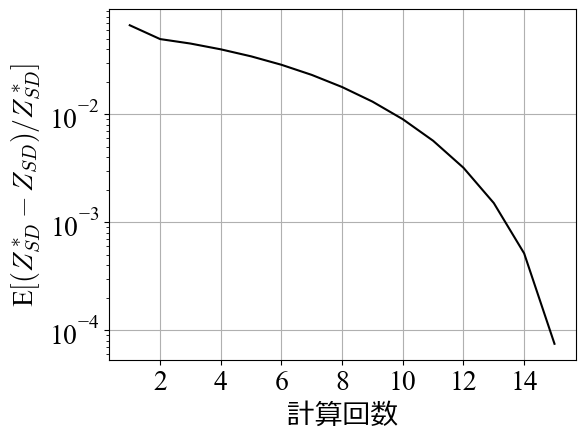

K=30
itr_list: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


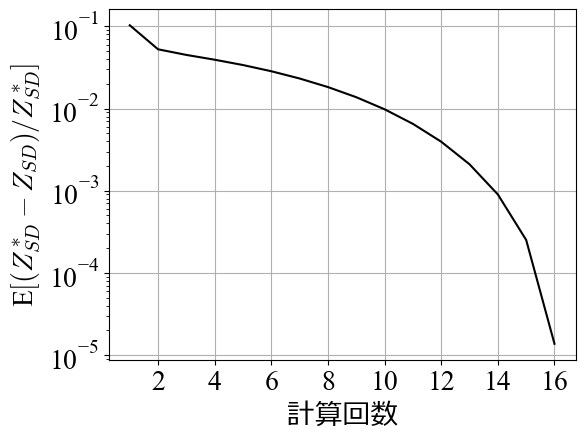

In [11]:
Col_list = [20, 30]
for Col in Col_list:
    print("="*40)
    print(f"K={Col}")

    K = Col * Col

    M = 90
    N = 90

#         dF_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
#             fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_F.xlsx')
#         dH_long = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/log/excelfile/' \
#             fr'shortlong/kaisekikai/theta=5.0/mesh/E={E}/v_proj=0.1/K={Col}^2/truevalue/jikken_H.xlsx')

#         m_fixed = np.array(dF_long['m'].tolist())
#         n_fixed = np.array(dH_long['n'].tolist()).reshape(K, K)

    m_per = M / K
    m_fixed = np.array([m_per] * K)
    n_fixed = np.full((K, K), N / (K * K))

    # Scaling * tが格子の最小距離となる。

    Scaling = 300 / Col

    alter_T_num = 0.5

    city_network = lattice.make_lattice(Col)

    # 通勤費用パラメータ
    t = 0.1

    # 距離抵抗パラメータ
    tau = 0.01

    # 総土地供給量
    S_total = 900
    S_bar = S_total / K

    Coordinate_Data = \
    np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
               city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
    distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

    theta_firm = 5.0
    theta_house = 5.0

    alpha_1 = 0.4
    alpha_2 = 0.4
    beta_1 = 0.4
    beta_2 = 0.4

    L = 0.2
    eta = 1.2
    p_proj = 1e-3

    RW_ini = 1.0
    RW_proj = 1e-3
    err_short = "obj_smaller_1e-4"

    method = "FISTA"
    long = "ichiyou"
    dic = "mesh_300divCol"

    R_ini = np.ones(K)
    W_ini = np.ones(K)

    #パラメータ設定
    prm = exp_parameter.Parameter(
                Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
                theta_firm, theta_house, E, RW_proj, alter_T_num,
                alpha_1, alpha_2, beta_1, beta_2, M, N)

    algprm = exp_parameter.Algo_Parameter(L, eta, p_proj)
    short = exp_Short_FISTA.Short(prm, algprm)

    dF = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/exp/excelfile/' \
                  fr'short/long_{long}/{method}/err_short={err_short}/{dic}/RW_proj={prm.RW_proj}/alter_T_num={prm.alter_T_num}/' \
                  fr'L={algprm.L}/eta={algprm.eta}/p_proj={algprm.p_proj}/E={prm.E}/K={prm.Col}^2/rel/jikken_F.xlsx')

    dF2 = pd.read_excel(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/exp/excelfile/' \
                fr'short/long_{long}/{method}/err_short={err_short}/{dic}/RW_proj={prm.RW_proj}/alter_T_num={prm.alter_T_num}/' \
                fr'L={algprm.L}/eta={algprm.eta}/p_proj={algprm.p_proj}/E={prm.E}/K={prm.Col}^2/nume_num/jikken.xlsx')

    obj_rel_list = np.array(dF['obj_rel'].tolist())
    itr_list = np.array(dF2['iteration'].tolist())
    
    print("itr_list:", itr_list)

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'cm'  # 数式フォントもTimes New Romanに設定

    font_path = r'C:\Windows\Fonts\meiryo.ttc'  # フォントのパスを指定
    jp_font = FontProperties(fname=font_path)

    plt.plot(itr_list, obj_rel_list, color="k")
    plt.yscale('log')

    # plt.title('m')
    plt.xlabel('計算回数', fontproperties=jp_font, fontsize=20)
    plt.ylabel('E$[(Z_{SD}^* - Z_{SD}) / Z_{SD}^*]$', fontsize=20)

    # plt.yticks([1e-1, 1e-2, 1e-3])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # plt.xlim(left=1, right=8)
    # plt.ylim(top=1e-2)

    plt.grid(True)

    plt.subplots_adjust(left=0.17, bottom=0.15)

    # folder_path = fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/exp/graph/' \
    #               fr'shortlong/{method}/err_short={err_short}/err_long={err_long}/{dic}/RW_proj={prm.RW_proj}/alter_T_num={prm.alter_T_num}/' \
    #               fr'L={algprm.L}/eta={algprm.eta}/p_proj={algprm.p_proj}/E={prm.E}/K={prm.Col}^2/nume_num'

    # create_folder(folder_path)

    # plt.savefig(fr'C:/Users/kimura/OneDrive - 国立大学法人東北大学/numerical/short_dual/exp/graph/' \
    #             fr'shortlong/{method}/err_short={err_short}/err_long={err_long}/{dic}/RW_proj={prm.RW_proj}/alter_T_num={prm.alter_T_num}/' \
    #             fr'L={algprm.L}/eta={algprm.eta}/p_proj={algprm.p_proj}/E={prm.E}/K={prm.Col}^2/nume_num/theta.jpg', format='jpg')

    plt.show()